# Differential Abundance Analysis

In [ ]:
import os
os.chdir('../')

--- Differential Abundance Analysis for: processing_data/log_transformed_mtb.tsv ---
Shape of loaded processed dataset: (352, 59833)
Identified 59831 feature columns for DAA.
Number of CD samples: 155
Number of UC samples: 96
Number of nonIBD samples: 101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



--- Results for CD_vs_UC ---
Top 10 features (sorted by Parametric Adjusted P-Value):
                 Feature  Adjusted_P_Value_Parametric  \
156570  HILp_QI13562__NA                 1.811728e-13   
18303   C18n_QI13546__NA                 1.903581e-13   
142035   HILp_QI1966__NA                 2.450185e-13   
135393  HILp_QI12841__NA                 2.563620e-13   
153873  HILp_QI13561__NA                 2.868954e-13   
124329   HILn_QI1058__NA                 3.698610e-13   
39474    C18n_QI8078__NA                 1.248009e-12   
154617  HILp_QI13845__NA                 1.575893e-12   
131733   HILp_QI6434__NA                 2.987636e-12   
154773  HILp_QI13254__NA                 3.606892e-12   

        Adjusted_P_Value_NonParametric  Log2_Fold_Change  
156570                    4.103914e-11         -1.698437  
18303                     5.073806e-12         -2.433034  
142035                    5.258270e-10         -1.662878  
135393                    1.762791e-11         -2

------------------------------

--- Results for CD_vs_nonIBD ---
Top 10 features (sorted by Parametric Adjusted P-Value):
                 Feature  Adjusted_P_Value_Parametric  \
4882     C18n_QI1872__NA                 3.583193e-19   
28330   C18n_QI10930__NA                 7.026136e-19   
15988    C18n_QI3060__NA                 8.030057e-19   
5131     C18n_QI2596__NA                 1.954206e-18   
76774    C8p_QI10300__NA                 1.971677e-18   
126979   HILn_QI7589__NA                 2.842854e-18   
7930      C18n_QI382__NA                 5.088905e-18   
5233     C18n_QI1728__NA                 6.785789e-18   
10105     C18n_QI846__NA                 1.041748e-17   
4762      C18n_QI413__NA                 1.183690e-17   

        Adjusted_P_Value_NonParametric  Log2_Fold_Change  
4882                      7.266689e-13         -1.544459  
28330                     1.434734e-15          7.337266  
15988                     5.501922e-16         14.044502  
5131          

------------------------------

--- Results for UC_vs_nonIBD ---
Top 10 features (sorted by Parametric Adjusted P-Value):
                 Feature  Adjusted_P_Value_Parametric  \
115382   HILn_QI3132__NA                 9.309947e-30   
115937   HILn_QI1958__NA                 9.725850e-30   
115364   HILn_QI3195__NA                 1.844101e-29   
138740   HILp_QI3060__NA                 2.417368e-29   
18302   C18n_QI13541__NA                 3.778550e-29   
15989    C18n_QI3060__NA                 5.435869e-29   
10106     C18n_QI846__NA                 6.655360e-29   
38204    C18n_QI7605__NA                 8.178555e-29   
38201    C18n_QI7515__NA                 2.145682e-28   
38168    C18n_QI6575__NA                 2.358997e-28   

        Adjusted_P_Value_NonParametric  Log2_Fold_Change  
115382                    7.017549e-21         -3.160621  
115937                    7.017549e-21          8.968057  
115364                    3.426970e-20         -2.959338  
138740        

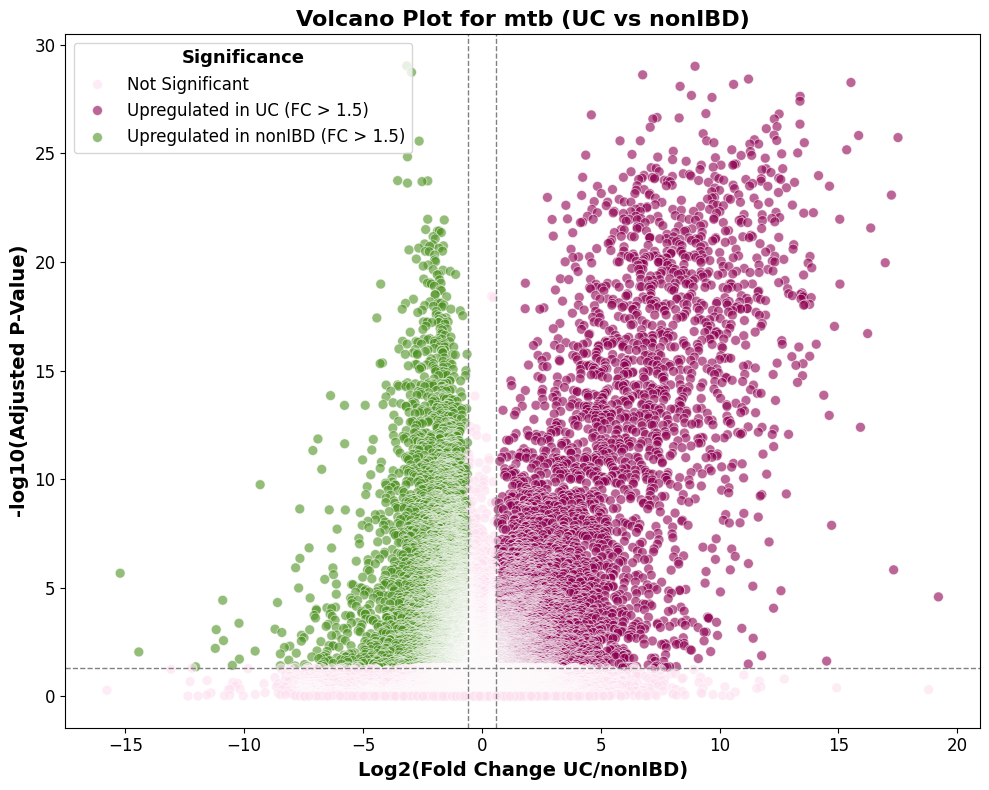

------------------------------
------------------------------


In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests # For FDR correction
warnings.filterwarnings('ignore')

# --- Load the Log-Transformed, Imputed, Filtered Dataset ---
file_path_step6 = 'processing_data/log_transformed_mtb.tsv'
dataset_name = 'mtb'

try:
    processed_df = pd.read_csv(file_path_step6, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_step6} was not found.")

print(f"--- Differential Abundance Analysis for: {file_path_step6} ---")
print(f"Shape of loaded processed dataset: {processed_df.shape}")

# --- Identify Feature Columns and Separate Groups ---
feature_columns = [col for col in processed_df.columns if col not in ['Sample', 'Study.Group']]
metadata_columns = ['Sample', 'Study.Group']

if not feature_columns:
    print("No feature columns found. Exiting DAA for this dataset.")
else:
    print(f"Identified {len(feature_columns)} feature columns for DAA.")

    # Separate CD, UC, and nonIBD groups
    cd_samples = processed_df[processed_df['Study.Group'] == 'CD']
    uc_samples = processed_df[processed_df['Study.Group'] == 'UC']
    nonibd_samples = processed_df[processed_df['Study.Group'] == 'nonIBD']

    # Check if we have enough samples in each group
    if cd_samples.empty or uc_samples.empty or nonibd_samples.empty:
        print("Error: Not enough samples in one or more groups (CD, UC, nonIBD) to perform DAA.")
    else:
        print(f"Number of CD samples: {len(cd_samples)}")
        print(f"Number of UC samples: {len(uc_samples)}")
        print(f"Number of nonIBD samples: {len(nonibd_samples)}")
        
        # a function to perform both parametric and non-parametric tests
        def run_statistical_tests(group1_values, group2_values, group1_name, group2_name, feature):
            # Skip if not enough data points
            if len(group1_values) < 2 or len(group2_values) < 2:
                return None
            
            # Parametric test (Welch's t-test)
            t_stat, p_value_param = stats.ttest_ind(group1_values, group2_values, equal_var=False, nan_policy='omit')
            
            # Non-parametric test (Mann-Whitney U test)
            u_stat, p_value_nonparam = stats.mannwhitneyu(group1_values, group2_values, alternative='two-sided')
            
            # Calculate fold change
            mean_group1_original_scale = np.mean(np.expm1(group1_values))
            mean_group2_original_scale = np.mean(np.expm1(group2_values))
            
            if mean_group2_original_scale != 0 and pd.notna(mean_group2_original_scale) and pd.notna(mean_group1_original_scale):
                fold_change = mean_group1_original_scale / mean_group2_original_scale
                log2_fold_change = np.log2(fold_change) if fold_change > 0 else (np.log2(abs(fold_change)) * (-1) if fold_change < 0 else 0)
            else:
                fold_change = np.nan
                log2_fold_change = np.nan
                
            return {
                'Feature': feature,
                'Comparison': f'{group1_name}_vs_{group2_name}',
                'P_Value_Parametric': p_value_param,
                'P_Value_NonParametric': p_value_nonparam,
                'Fold_Change': fold_change,
                'Log2_Fold_Change': log2_fold_change,
                f'Mean_{group1_name}_Log': np.mean(group1_values),
                f'Mean_{group2_name}_Log': np.mean(group2_values)
            }
        
        comparisons = [
            (cd_samples, uc_samples, 'CD', 'UC'),
            (cd_samples, nonibd_samples, 'CD', 'nonIBD'),
            (uc_samples, nonibd_samples, 'UC', 'nonIBD')
        ]
        
        all_results = []
        
        # Run analyses for all features across all comparisons
        for feature in feature_columns:
            for group1, group2, group1_name, group2_name in comparisons:
                group1_values = group1[feature].dropna()
                group2_values = group2[feature].dropna()
                
                result = run_statistical_tests(group1_values, group2_values, group1_name, group2_name, feature)
                if result:
                    all_results.append(result)
        
        results_df = pd.DataFrame(all_results)
        
        # Apply FDR correction across all tests and comparisons
        if not results_df.empty:
            # Correct parametric p-values
            reject_param, pvals_corrected_param, _, _ = multipletests(results_df['P_Value_Parametric'], method='fdr_bh')
            results_df['Adjusted_P_Value_Parametric'] = pvals_corrected_param
            results_df['Is_Significant_Parametric_FDR_0.05'] = reject_param
            
            # Correct non-parametric p-values
            reject_nonparam, pvals_corrected_nonparam, _, _ = multipletests(results_df['P_Value_NonParametric'], method='fdr_bh')
            results_df['Adjusted_P_Value_NonParametric'] = pvals_corrected_nonparam
            results_df['Is_Significant_NonParametric_FDR_0.05'] = reject_nonparam
            
            # Sort by parametric adjusted p-value for display
            results_df = results_df.sort_values(by=['Comparison', 'Adjusted_P_Value_Parametric'])
            
            # Display results for each comparison
            for comparison in ['CD_vs_UC', 'CD_vs_nonIBD', 'UC_vs_nonIBD']:
                comparison_results = results_df[results_df['Comparison'] == comparison]
                
                print(f"\n--- Results for {comparison} ---")
                print(f"Top 10 features (sorted by Parametric Adjusted P-Value):")
                if not comparison_results.empty:
                    display_cols = ['Feature', 'Adjusted_P_Value_Parametric', 'Adjusted_P_Value_NonParametric', 'Log2_Fold_Change']
                    print(comparison_results[display_cols].head(10))
                    
                    # Count significant hits
                    sig_param = comparison_results[comparison_results['Is_Significant_Parametric_FDR_0.05'] == True]
                    sig_nonparam = comparison_results[comparison_results['Is_Significant_NonParametric_FDR_0.05'] == True]
                    
                    print(f"\nFeatures significant at FDR < 0.05:")
                    print(f"Parametric (Welch's t-test): {len(sig_param)}")
                    print(f"Non-parametric (Mann-Whitney U): {len(sig_nonparam)}")
                    
                    # Create volcano plot for each comparison
                    plot_df = comparison_results.dropna(subset=['Log2_Fold_Change', 'Adjusted_P_Value_Parametric']).copy()

                    if not plot_df.empty:
                        plot_df['-log10_AdjPValue'] = -np.log10(plot_df['Adjusted_P_Value_Parametric'])
                        plot_df.replace([np.inf, -np.inf], np.nanmax(plot_df['-log10_AdjPValue'][np.isfinite(plot_df['-log10_AdjPValue'])]), inplace=True)

                        plt.figure(figsize=(10, 8))

                        # Significance thresholds
                        fdr_threshold = 0.05
                        log2fc_threshold = np.log2(1.5)

                        # Parse group names from comparison
                        group1, group2 = comparison.split('_vs_')

                        # Create a 'Significant' column for coloring
                        plot_df['Significant'] = 'Not Significant'
                        plot_df.loc[(plot_df['Adjusted_P_Value_Parametric'] < fdr_threshold) &
                                    (plot_df['Log2_Fold_Change'] > log2fc_threshold), 'Significant'] = f'Upregulated in {group1} (FC > {2**log2fc_threshold:.1f})'
                        plot_df.loc[(plot_df['Adjusted_P_Value_Parametric'] < fdr_threshold) &
                                    (plot_df['Log2_Fold_Change'] < -log2fc_threshold), 'Significant'] = f'Upregulated in {group2} (FC > {2**log2fc_threshold:.1f})'

                        custom_colors = ['#fde0ef',   # Light pink for not significant
                                        '#8e0152',   # Dark pink/red for upregulated in group1  
                                        '#4d9221']   # Dark green for upregulated in group2

                        sns.scatterplot(
                            x='Log2_Fold_Change',
                            y='-log10_AdjPValue',
                            hue='Significant',
                            hue_order = ['Not Significant',
                                        f'Upregulated in {group1} (FC > {2**log2fc_threshold:.1f})',
                                        f'Upregulated in {group2} (FC > {2**log2fc_threshold:.1f})'],
                            palette={'Not Significant': custom_colors[0],
                                    f'Upregulated in {group1} (FC > {2**log2fc_threshold:.1f})': custom_colors[1],
                                    f'Upregulated in {group2} (FC > {2**log2fc_threshold:.1f})': custom_colors[2]},
                            data=plot_df,
                            alpha=0.6,
                            s=50
                        )

                        # threshold lines (keeping the dashed lines for reference)
                        plt.axvline(log2fc_threshold, color='grey', linestyle='--', lw=1)
                        plt.axvline(-log2fc_threshold, color='grey', linestyle='--', lw=1)
                        plt.axhline(-np.log10(fdr_threshold), color='grey', linestyle='--', lw=1)

                        # labels and legend with increased font sizes
                        plt.title(f'Volcano Plot for {dataset_name} ({group1} vs {group2})', fontsize=16, fontweight='bold')
                        plt.xlabel(f'Log2(Fold Change {group1}/{group2})', fontsize=14, fontweight='bold')
                        plt.ylabel('-log10(Adjusted P-Value)', fontsize=14, fontweight='bold')
                        
                        plt.xticks(fontsize=12)
                        plt.yticks(fontsize=12)
                        
                        legend = plt.legend(fontsize=12, title_fontsize=13, title='Significance')
                        legend.set_title('Significance', prop={'size': 13, 'weight': 'bold'})
                        
                        plt.grid(False)
                        
                        plt.tight_layout()
                        plt.show()

                    else:
                        print("Not enough data to create volcano plot after dropping NaNs.")
                else:
                    print("No results available for this comparison.")
                print("-" * 30)
            
            results_df.to_csv(f"processing_data/{dataset_name}_multigroup_daa_results.csv", index=False)
        else:
            print("No results to process after statistical tests (results_df is empty).")
        print("-" * 30)

Overlapping Features

In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
warnings.filterwarnings('ignore')

# Load the saved results file
results_file = 'processing_data/mtb_multigroup_daa_results.csv'
results_df = pd.read_csv(results_file)

# Define significance thresholds
fdr_threshold = 0.05
log2fc_threshold = np.log2(1.5)  # Same as in the original analysis

# Function to identify significant features for a specific group in a comparison
def get_significant_features(df, comparison, upregulated_group, other_group, test_type='Parametric'):
    """
    Extracts features significantly upregulated in the specified group for a given comparison.
    
    Parameters:
    - df: DataFrame with results
    - comparison: e.g., 'CD_vs_UC'
    - upregulated_group: The group with higher abundance, e.g., 'CD'
    - other_group: The comparison group, e.g., 'UC'
    - test_type: 'Parametric' or 'NonParametric'
    
    Returns:
    - Set of significant feature names
    """
    # Filter for the specific comparison
    comp_df = df[df['Comparison'] == comparison].copy()
    
    # Direction of fold change depends on the order in the comparison
    if comparison.startswith(f"{upregulated_group}_vs_"):
        # Group of interest is first, so looking for positive log2FC
        direction = '>'
    else:
        # Group of interest is second, so looking for negative log2FC
        direction = '<'
    
    # Filter for significant features based on adjusted p-value and fold change
    if direction == '>':
        sig_features = comp_df[(comp_df[f'Adjusted_P_Value_{test_type}'] < fdr_threshold) & 
                              (comp_df['Log2_Fold_Change'] > log2fc_threshold)]['Feature'].tolist()
    else:
        sig_features = comp_df[(comp_df[f'Adjusted_P_Value_{test_type}'] < fdr_threshold) & 
                              (comp_df['Log2_Fold_Change'] < -log2fc_threshold)]['Feature'].tolist()
    
    return set(sig_features)

# UC significant features from both relevant comparisons
uc_cd_uc_features = get_significant_features(results_df, 'CD_vs_UC', 'UC', 'CD')
uc_nonibd_uc_features = get_significant_features(results_df, 'UC_vs_nonIBD', 'UC', 'nonIBD')

# CD significant features from both relevant comparisons
cd_uc_cd_features = get_significant_features(results_df, 'CD_vs_UC', 'CD', 'UC')
cd_nonibd_cd_features = get_significant_features(results_df, 'CD_vs_nonIBD', 'CD', 'nonIBD')

# to calculate overlaps
uc_overlap = uc_cd_uc_features.intersection(uc_nonibd_uc_features)
cd_overlap = cd_uc_cd_features.intersection(cd_nonibd_cd_features)

print(f"Analysis of significant feature overlap (FDR < {fdr_threshold}, fold change > {2**log2fc_threshold:.1f}):")
print("\n1. UC Upregulated Features:")
print(f"   - UC vs CD comparison: {len(uc_cd_uc_features)} features")
print(f"   - UC vs nonIBD comparison: {len(uc_nonibd_uc_features)} features")
print(f"   - Overlap: {len(uc_overlap)} features ({(len(uc_overlap)/len(uc_cd_uc_features)*100 if len(uc_cd_uc_features) > 0 else 0):.1f}% of UC vs CD features)")

print("\n2. CD Upregulated Features:")
print(f"   - CD vs UC comparison: {len(cd_uc_cd_features)} features")
print(f"   - CD vs nonIBD comparison: {len(cd_nonibd_cd_features)} features")
print(f"   - Overlap: {len(cd_overlap)} features ({(len(cd_overlap)/len(cd_uc_cd_features)*100 if len(cd_uc_cd_features) > 0 else 0):.1f}% of CD vs UC features)")

uc_overlap_data = []
cd_overlap_data = []

# Function to get feature statistics
def get_feature_stats(feature, comparison):
    row = results_df[(results_df['Feature'] == feature) & (results_df['Comparison'] == comparison)]
    if not row.empty:
        return {
            'Feature': feature,
            'Comparison': comparison,
            'P_Value_Parametric': row['P_Value_Parametric'].values[0],
            'Adj_P_Value_Parametric': row['Adjusted_P_Value_Parametric'].values[0],
            'P_Value_NonParametric': row['P_Value_NonParametric'].values[0],
            'Adj_P_Value_NonParametric': row['Adjusted_P_Value_NonParametric'].values[0],
            'Log2_Fold_Change': row['Log2_Fold_Change'].values[0]
        }
    return None

# Collect UC overlap data
for feature in sorted(uc_overlap):
    uc_cd_stats = get_feature_stats(feature, 'CD_vs_UC')
    uc_nonibd_stats = get_feature_stats(feature, 'UC_vs_nonIBD')
    
    if uc_cd_stats and uc_nonibd_stats:
        # Add CD_vs_UC comparison
        uc_overlap_data.append({
            'Feature': feature,
            'Comparison': 'CD_vs_UC',
            'Disease': 'UC',
            'P_Value_Parametric': uc_cd_stats['P_Value_Parametric'],
            'Adj_P_Value_Parametric': uc_cd_stats['Adj_P_Value_Parametric'],
            'P_Value_NonParametric': uc_cd_stats['P_Value_NonParametric'],
            'Adj_P_Value_NonParametric': uc_cd_stats['Adj_P_Value_NonParametric'],
            'Log2_Fold_Change': uc_cd_stats['Log2_Fold_Change']
        })
        
        # Add UC_vs_nonIBD comparison
        uc_overlap_data.append({
            'Feature': feature,
            'Comparison': 'UC_vs_nonIBD',
            'Disease': 'UC',
            'P_Value_Parametric': uc_nonibd_stats['P_Value_Parametric'],
            'Adj_P_Value_Parametric': uc_nonibd_stats['Adj_P_Value_Parametric'],
            'P_Value_NonParametric': uc_nonibd_stats['P_Value_NonParametric'],
            'Adj_P_Value_NonParametric': uc_nonibd_stats['Adj_P_Value_NonParametric'],
            'Log2_Fold_Change': uc_nonibd_stats['Log2_Fold_Change']
        })

# Collect CD overlap data
for feature in sorted(cd_overlap):
    cd_uc_stats = get_feature_stats(feature, 'CD_vs_UC')
    cd_nonibd_stats = get_feature_stats(feature, 'CD_vs_nonIBD')
    
    if cd_uc_stats and cd_nonibd_stats:
        # Add CD_vs_UC comparison
        cd_overlap_data.append({
            'Feature': feature,
            'Comparison': 'CD_vs_UC',
            'Disease': 'CD',
            'P_Value_Parametric': cd_uc_stats['P_Value_Parametric'],
            'Adj_P_Value_Parametric': cd_uc_stats['Adj_P_Value_Parametric'],
            'P_Value_NonParametric': cd_uc_stats['P_Value_NonParametric'],
            'Adj_P_Value_NonParametric': cd_uc_stats['Adj_P_Value_NonParametric'],
            'Log2_Fold_Change': cd_uc_stats['Log2_Fold_Change']
        })
        
        # Add CD_vs_nonIBD comparison
        cd_overlap_data.append({
            'Feature': feature,
            'Comparison': 'CD_vs_nonIBD',
            'Disease': 'CD',
            'P_Value_Parametric': cd_nonibd_stats['P_Value_Parametric'],
            'Adj_P_Value_Parametric': cd_nonibd_stats['Adj_P_Value_Parametric'],
            'P_Value_NonParametric': cd_nonibd_stats['P_Value_NonParametric'],
            'Adj_P_Value_NonParametric': cd_nonibd_stats['Adj_P_Value_NonParametric'],
            'Log2_Fold_Change': cd_nonibd_stats['Log2_Fold_Change']
        })

# Convert to DataFrames
uc_overlap_df = pd.DataFrame(uc_overlap_data) if uc_overlap_data else pd.DataFrame()
cd_overlap_df = pd.DataFrame(cd_overlap_data) if cd_overlap_data else pd.DataFrame()

# Uncomment to save
# if not uc_overlap_df.empty:
#     uc_overlap_df.to_csv('uc_overlapping_features.csv', index=False)
#     print(f"\nSaved {len(uc_overlap)} UC overlapping features to uc_overlapping_features.csv")

# if not cd_overlap_df.empty:
#     cd_overlap_df.to_csv('cd_overlapping_features.csv', index=False)
#     print(f"Saved {len(cd_overlap)} CD overlapping features to cd_overlapping_features.csv")

summary_data = []

# UC summary
if len(uc_cd_uc_features) > 0:
    uc_overlap_percentage = (len(uc_overlap)/len(uc_cd_uc_features))*100
else:
    uc_overlap_percentage = 0

summary_data.append({
    'Disease': 'UC',
    'Features_vs_CD': len(uc_cd_uc_features),
    'Features_vs_nonIBD': len(uc_nonibd_uc_features),
    'Overlapping_Features': len(uc_overlap),
    'Overlap_Percentage': uc_overlap_percentage
})

# CD summary
if len(cd_uc_cd_features) > 0:
    cd_overlap_percentage = (len(cd_overlap)/len(cd_uc_cd_features))*100
else:
    cd_overlap_percentage = 0

summary_data.append({
    'Disease': 'CD',
    'Features_vs_Other_IBD': len(cd_uc_cd_features),
    'Features_vs_nonIBD': len(cd_nonibd_cd_features),
    'Overlapping_Features': len(cd_overlap),
    'Overlap_Percentage': cd_overlap_percentage
})

summary_df = pd.DataFrame(summary_data)
# summary_df.to_csv('overlapping_features_summary.csv', index=False)
# print("Saved summary statistics to overlapping_features_summary.csv")

# Venn diagrams to visualize the overlaps
plt.figure(figsize=(16, 8))

colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# UC features overlap
plt.subplot(1, 2, 1)
v1 = venn2([uc_cd_uc_features, uc_nonibd_uc_features], 
           set_labels=('UC vs CD\n(UC upregulated)', 'UC vs nonIBD\n(UC upregulated)'))

# UC Venn diagram colors
if v1.get_patch_by_id('10'):
    v1.get_patch_by_id('10').set_facecolor(colors[1])  # '#c51b7d' - UC vs CD only
    v1.get_patch_by_id('10').set_alpha(0.7)
if v1.get_patch_by_id('01'):
    v1.get_patch_by_id('01').set_facecolor(colors[7])  # '#7fbc41' - UC vs nonIBD only  
    v1.get_patch_by_id('01').set_alpha(0.7)
if v1.get_patch_by_id('11'):
    v1.get_patch_by_id('11').set_facecolor(colors[3])  # '#f1b6da' - overlap
    v1.get_patch_by_id('11').set_alpha(0.8)

for text in v1.set_labels:
    if text:
        text.set_fontsize(20)
        text.set_fontweight('regular')
for text in v1.subset_labels:
    if text:
        text.set_fontsize(20)
        text.set_fontweight('semibold')

plt.title('UC Upregulated Features Overlap', fontsize=20, fontweight='semibold', pad=20)

# CD features overlap
plt.subplot(1, 2, 2)
v2 = venn2([cd_uc_cd_features, cd_nonibd_cd_features], 
           set_labels=('CD vs UC\n(CD upregulated)', 'CD vs nonIBD\n(CD upregulated)'))

# CD Venn diagram colors
if v2.get_patch_by_id('10'):
    v2.get_patch_by_id('10').set_facecolor(colors[1])  # '#8e0152' - CD vs UC only
    v2.get_patch_by_id('10').set_alpha(0.7)
if v2.get_patch_by_id('01'):
    v2.get_patch_by_id('01').set_facecolor(colors[8])  # '#4d9221' - CD vs nonIBD only
    v2.get_patch_by_id('01').set_alpha(0.7)
if v2.get_patch_by_id('11'):
    v2.get_patch_by_id('11').set_facecolor(colors[5])  # '#e6f5d0' - overlap
    v2.get_patch_by_id('11').set_alpha(0.8)

for text in v2.set_labels:
    if text:
        text.set_fontsize(20)
        text.set_fontweight('regular')
for text in v2.subset_labels:
    if text:
        text.set_fontsize(20)
        text.set_fontweight('semibold')

plt.title('CD Upregulated Features Overlap', fontsize=20, fontweight='semibold', pad=20)

plt.tight_layout()
plt.show()

if not uc_overlap_df.empty or not cd_overlap_df.empty:
    all_overlaps_df = pd.concat([uc_overlap_df, cd_overlap_df], ignore_index=True)
    all_overlaps_df.to_csv('processing_data/all_overlapping_features.csv', index=False)
    print("Saved all overlapping features to all_overlapping_features.csv")

Analysis of significant feature overlap (FDR < 0.05, fold change > 1.5):

1. UC Upregulated Features:
   - UC vs CD comparison: 3630 features
   - UC vs nonIBD comparison: 7555 features
   - Overlap: 2414 features (66.5% of UC vs CD features)

2. CD Upregulated Features:
   - CD vs UC comparison: 5629 features
   - CD vs nonIBD comparison: 7219 features
   - Overlap: 879 features (15.6% of CD vs UC features)
Saved summary statistics to overlapping_features_summary.csv


Saved all overlapping features to all_overlapping_features.csv


In [5]:
import pandas as pd

# Load all_overlapping_features.csv and extract unique feature names
all_features_df = pd.read_csv('processing_data/all_overlapping_features.csv')
unique_features = all_features_df['Feature'].unique()
print(f"Found {len(unique_features)} unique overlapping features")

print("Example feature names:")
for feature in list(unique_features)[:5]:
    print(f"  - {feature}")

# Load the log-transformed data
mtb_data = pd.read_csv('processing_data/log_transformed_mtb.tsv', sep='\t')

# Check structure of the file
print(f"Original MTB data shape: {mtb_data.shape}")
print(f"Number of samples (rows): {mtb_data.shape[0]}")
print(f"Number of columns (including metadata): {mtb_data.shape[1]}")

# Separate metadata and feature columns
metadata_cols = ['Sample', 'Study.Group']
feature_cols = [col for col in mtb_data.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]

print(f"Found {len(feature_cols)} feature columns in the original data")

# Filter to keep only the overlapping features
overlapping_feature_cols = [col for col in feature_cols if col in unique_features]
print(f"Found {len(overlapping_feature_cols)} matching overlapping features")

# Create the filtered dataframe with metadata + overlapping features
filtered_columns = metadata_cols + overlapping_feature_cols
filtered_mtb = mtb_data[filtered_columns]

# Save the filtered data
print(f"Original columns: {mtb_data.shape[1]}, Filtered columns: {filtered_mtb.shape[1]}")
print(f"Kept {len(overlapping_feature_cols)} out of {len(feature_cols)} features")

filtered_mtb.to_csv('processing_data/filtered_log_transformed_mtb_overlap.tsv', sep='\t', index=False)

print(f"Saved filtered data to 'filtered_log_transformed_mtb.tsv'")

# Check if all unique features were found in the mtb data
missing_features = set(unique_features) - set(overlapping_feature_cols)

if missing_features:
    print(f"Warning: {len(missing_features)} features from all_overlapping_features.csv were not found in the MTB data:")
    for feat in list(missing_features)[:10]:  # Show first 10 missing features
        print(f"  - {feat}")
    if len(missing_features) > 10:
        print(f"  - ... and {len(missing_features) - 10} more")
else:
    print("All overlapping features were found in the MTB data")

Found 3293 unique overlapping features
Example feature names:
  - C18n_QI10046__NA
  - C18n_QI100__NA
  - C18n_QI10109__NA
  - C18n_QI10111__NA
  - C18n_QI1015__NA
Original MTB data shape: (352, 59833)
Number of samples (rows): 352
Number of columns (including metadata): 59833
Found 59831 feature columns in the original data
Found 3293 matching overlapping features
Original columns: 59833, Filtered columns: 3295
Kept 3293 out of 59831 features
Saved filtered data to 'filtered_log_transformed_mtb.tsv'
All overlapping features were found in the MTB data


# Subtype Discovery

--- Subtype Discovery (K-means K selection) for: processing_data/filtered_log_transformed_mtb_overlap.tsv ---
Shape of loaded processed dataset: (352, 3295)
Identified 3293 feature columns for clustering.
Shape of feature matrix for clustering: (352, 3293)
Features standardized for clustering.
------------------------------

--- Elbow Method for Optimal K ---
SSE for K=2: 829691.87
SSE for K=3: 779256.76
SSE for K=4: 756797.92
SSE for K=5: 739378.96
SSE for K=6: 723705.30
SSE for K=7: 708976.04
SSE for K=8: 700229.02
SSE for K=9: 691109.10
SSE for K=10: 678747.76


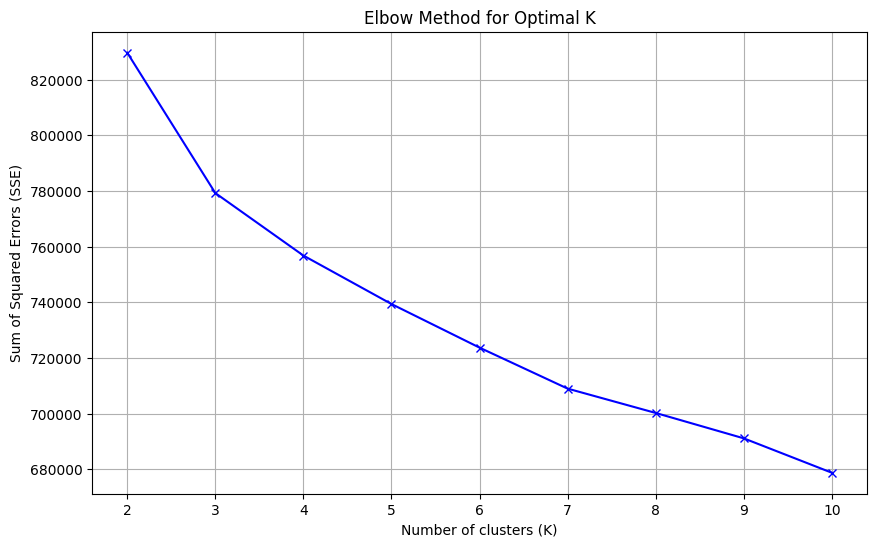

Look for an 'elbow' in the plot: a point where adding another cluster doesn't significantly reduce SSE.
------------------------------

--- Silhouette Analysis for Optimal K ---
Silhouette Score for K=2: 0.2821
Silhouette Score for K=3: 0.1295
Silhouette Score for K=4: 0.0769
Silhouette Score for K=5: 0.0648
Silhouette Score for K=6: 0.0544
Silhouette Score for K=7: 0.0555
Silhouette Score for K=8: 0.0496
Silhouette Score for K=9: 0.0493
Silhouette Score for K=10: 0.0482


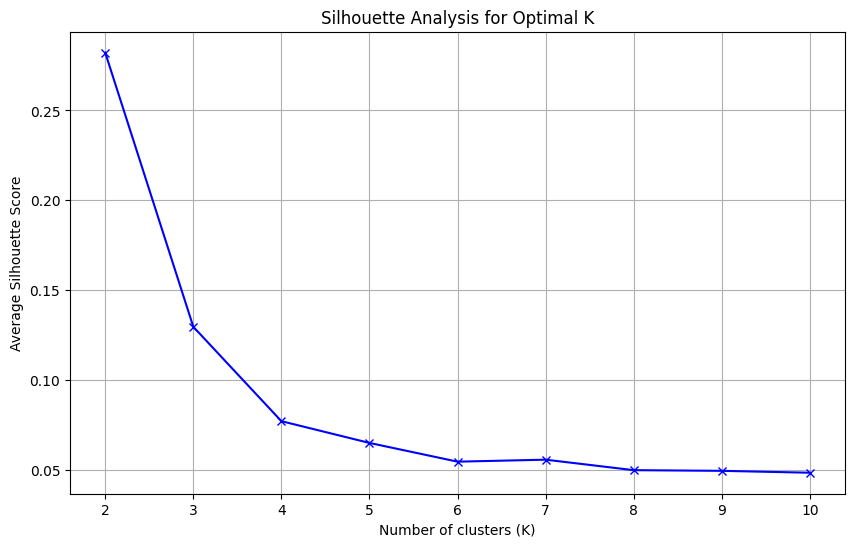

Look for the K that maximizes the Silhouette Score. Values closer to +1 are better.
------------------------------


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# --- 1. Load Processed (Log-Transformed, Imputed, Filtered) Dataset ---
file_path_step6 = 'processing_data/filtered_log_transformed_mtb_overlap.tsv'
dataset_name = 'mtb'

try:
    processed_df = pd.read_csv(file_path_step6, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_step6} was not found.")


print(f"--- Subtype Discovery (K-means K selection) for: {file_path_step6} ---")
print(f"Shape of loaded processed dataset: {processed_df.shape}")

# --- 2. Prepare Data for Clustering ---
feature_columns = [col for col in processed_df.columns if col not in ['Sample', 'Study.Group']]

if not feature_columns:
    print("No feature columns found. Exiting clustering for this dataset.")
else:
    print(f"Identified {len(feature_columns)} feature columns for clustering.")
    features_for_clustering = processed_df[feature_columns].copy()

    # Ensure all feature data is numeric (should already be done, so checking just in case)
    for col in features_for_clustering.columns:
        features_for_clustering[col] = pd.to_numeric(features_for_clustering[col], errors='coerce')
    
    # Drop any columns that might have become all NaN after coercion (unlikely but a safeguard)
    features_for_clustering.dropna(axis=1, how='all', inplace=True)
    # Drop any rows that might have all NaNs in features (also unlikely)
    features_for_clustering.dropna(axis=0, how='all', inplace=True)
    
    if features_for_clustering.empty or features_for_clustering.shape[1] == 0:
        print("No valid feature data remains after NaN checks. Cannot proceed with clustering.")
    else:
        print(f"Shape of feature matrix for clustering: {features_for_clustering.shape}")

        # Scale the features: K-means is distance-based, so scaling is important.
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features_for_clustering)
        print("Features standardized for clustering.")
        print("-" * 30)

        # --- 3. Determine Optimal K using Elbow Method ---
        print("\n--- Elbow Method for Optimal K ---")
        sse = {} # Sum of squared errors
        k_range = range(2, 11) # Test K from 2 to 10 clusters

        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
            kmeans.fit(scaled_features)
            sse[k] = kmeans.inertia_ # Inertia: Sum of squared distances of samples to their closest cluster center.
            print(f"SSE for K={k}: {sse[k]:.2f}")

        plt.figure(figsize=(10, 6))
        plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
        plt.xlabel('Number of clusters (K)')
        plt.ylabel('Sum of Squared Errors (SSE)')
        plt.title('Elbow Method for Optimal K')
        plt.xticks(list(k_range))
        plt.grid(True)
        plt.show()
        print("Look for an 'elbow' in the plot: a point where adding another cluster doesn't significantly reduce SSE.")
        print("-" * 30)

        # --- 4. Determine Optimal K using Silhouette Analysis ---
        print("\n--- Silhouette Analysis for Optimal K ---")
        silhouette_scores = {}
        for k in k_range: # Same K range (must be >= 2)
            kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
            cluster_labels = kmeans.fit_predict(scaled_features)
            try:
                silhouette_avg = silhouette_score(scaled_features, cluster_labels)
                silhouette_scores[k] = silhouette_avg
                print(f"Silhouette Score for K={k}: {silhouette_avg:.4f}")
            except ValueError as e:
                print(f"Could not calculate silhouette score for K={k}: {e}. This can happen if a cluster has only 1 member.")
                silhouette_scores[k] = -1 # Assign a low score


        plt.figure(figsize=(10, 6))
        # Filter out K values where silhouette score could not be computed (marked as -1 or similar)
        valid_silhouette_k = [k for k, v in silhouette_scores.items() if v > -1]
        valid_silhouette_v = [v for k, v in silhouette_scores.items() if v > -1]
        
        if valid_silhouette_k:
            plt.plot(valid_silhouette_k, valid_silhouette_v, 'bx-')
            plt.xlabel('Number of clusters (K)')
            plt.ylabel('Average Silhouette Score')
            plt.title('Silhouette Analysis for Optimal K')
            plt.xticks(valid_silhouette_k)
            plt.grid(True)
            plt.show()
            print("Look for the K that maximizes the Silhouette Score. Values closer to +1 are better.")
        else:
            print("Could not plot silhouette scores as none were successfully computed.")
        print("-" * 30)

K-Means

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # For re-checking

# --- 1. Load Processed (Log-Transformed, Imputed, Filtered) Dataset ---
file_path_step6 = 'processing_data/filtered_log_transformed_mtb_overlap.tsv'
dataset_name = 'mtb'

try:
    log_transformed_df = pd.read_csv(file_path_step6, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_step6} was not found.")

print(f"--- Applying K-means for: {file_path_step6} ---")
print(f"Shape of loaded log-transformed dataset: {log_transformed_df.shape}")

# --- 2. Prepare Data for Clustering (as done for K estimation) ---
feature_columns = [col for col in log_transformed_df.columns if col not in ['Sample', 'Study.Group']]

if not feature_columns:
    print("No feature columns found. Exiting clustering.")
    scaled_features = None 
    features_for_clustering_indices = None
else:
    features_for_clustering = log_transformed_df[feature_columns].copy()
    for col in features_for_clustering.columns: # Ensure numeric
        features_for_clustering[col] = pd.to_numeric(features_for_clustering[col], errors='coerce')
    features_for_clustering.dropna(axis=1, how='all', inplace=True) # Drop all-NaN columns
    # This ensures cluster labels align with the correct samples later.
    original_indices = features_for_clustering.index 
    features_for_clustering.dropna(axis=0, how='all', inplace=True)
    # Realign log_transformed_df if rows were dropped (though, again, unlikely at this stage)
    log_transformed_df_aligned = log_transformed_df.loc[features_for_clustering.index]


    if features_for_clustering.empty or features_for_clustering.shape[1] == 0:
        print("No valid feature data remains. Cannot proceed.")
        scaled_features = None
    else:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features_for_clustering)
        print(f"Using {scaled_features.shape[1]} features for clustering from {scaled_features.shape[0]} samples.")
        print("-" * 30)

if scaled_features is not None and scaled_features.shape[0] > 0: # Proceed if we have data to cluster
    # --- 3. Apply K-means Clustering ---
    chosen_k = 2
    print(f"Applying K-means with K = {chosen_k}")

    kmeans = KMeans(n_clusters=chosen_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    # fit_predict on the data used for Silhouette/Elbow, which is features_for_clustering (after scaling)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Add cluster labels to the (potentially row-aligned) DataFrame
    clustered_df = log_transformed_df_aligned.copy()
    clustered_df['KMeans_Cluster'] = cluster_labels
    
    # Recalculate and print silhouette score for this specific clustering
    try:
        current_silhouette_score = silhouette_score(scaled_features, cluster_labels)
        print(f"Silhouette Score for chosen K={chosen_k}: {current_silhouette_score:.4f}")
    except ValueError as e:
        print(f"Could not calculate silhouette score for chosen K={chosen_k}: {e}")
    print("-" * 30)

    # --- 4. Characterize Clusters Numerically ---
    print("\n--- Cluster Characterization ---")
    print(f"Value counts for K-means Clusters (K={chosen_k}):")
    print(clustered_df['KMeans_Cluster'].value_counts().sort_index())
    
    if 'Study.Group' in clustered_df.columns:
        print("\nCross-tabulation of Study.Group vs. KMeans_Cluster:")
        print(pd.crosstab(clustered_df['Study.Group'], clustered_df['KMeans_Cluster']))
    else:
        print("'Study.Group' column not found in clustered_df for cross-tabulation.")
    print("-" * 30)

    # --- 5. Visualize Clusters using PCA ---
    # Perform PCA on the same scaled_features used for clustering
    print("\n--- Visualizing Clusters with PCA ---")
    pca_for_viz = PCA(n_components=2, random_state=42) 
    principal_components_viz = pca_for_viz.fit_transform(scaled_features)
    
    pca_viz_df = pd.DataFrame(
        data=principal_components_viz, 
        columns=['PC1_KMeans', 'PC2_KMeans'],
        index=clustered_df.index # Use index from clustered_df for correct alignment
    )
    
    # Combine PCA results with Study.Group and KMeans_Cluster labels
    pca_viz_df = pd.concat([pca_viz_df, clustered_df[['Sample', 'Study.Group', 'KMeans_Cluster']]], axis=1)

    plt.figure(figsize=(12, 9))
    scatter_plot = sns.scatterplot(
        x='PC1_KMeans', 
        y='PC2_KMeans', 
        hue='KMeans_Cluster', 
        style='Study.Group', # Use style to show original diagnosis
        palette=sns.color_palette('viridis', n_colors=chosen_k),
        data=pca_viz_df, 
        s=100, 
        alpha=0.8
    )
    plt.title(f'K-means Clusters (K={chosen_k}) on PCA of {dataset_name} Log-Transformed Data')
    plt.xlabel(f'PC1 ({pca_for_viz.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_for_viz.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(title='K-means Cluster / Diagnosis')
    plt.grid(True)
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.show()
    print("-" * 30)

else:
    print("Clustering skipped as no valid feature data was available.")

--- Applying K-means for: processing_data/filtered_log_transformed_mtb_overlap.tsv ---
Shape of loaded log-transformed dataset: (352, 3295)
Using 3293 features for clustering from 352 samples.
------------------------------
Applying K-means with K = 2
Silhouette Score for chosen K=2: 0.2821
------------------------------

--- Cluster Characterization ---
Value counts for K-means Clusters (K=2):
KMeans_Cluster
0    240
1    112
Name: count, dtype: int64

Cross-tabulation of Study.Group vs. KMeans_Cluster:
KMeans_Cluster    0   1
Study.Group            
CD              108  47
UC               31  65
nonIBD          101   0
------------------------------

--- Visualizing Clusters with PCA ---


------------------------------


# CD Subtype Identification

--- K-determination for CD Subtypes from: processing_data/filtered_log_transformed_mtb_overlap.tsv ---
Shape of loaded full dataset: (352, 3295)
Shape of CD-only dataset: (155, 3295)
Identified 3293 feature columns for clustering CD subtypes.
Shape of feature matrix for CD subtype clustering: (155, 3293)
CD features standardized for clustering.
------------------------------

--- Elbow Method for Optimal K (CD Subtypes) ---
SSE for K=2 (CD subtypes): 363279.82
SSE for K=3 (CD subtypes): 342730.74
SSE for K=4 (CD subtypes): 328955.47
SSE for K=5 (CD subtypes): 320882.08
SSE for K=6 (CD subtypes): 311115.35
SSE for K=7 (CD subtypes): 305368.24
SSE for K=8 (CD subtypes): 298478.57
SSE for K=9 (CD subtypes): 292020.88
SSE for K=10 (CD subtypes): 286299.20


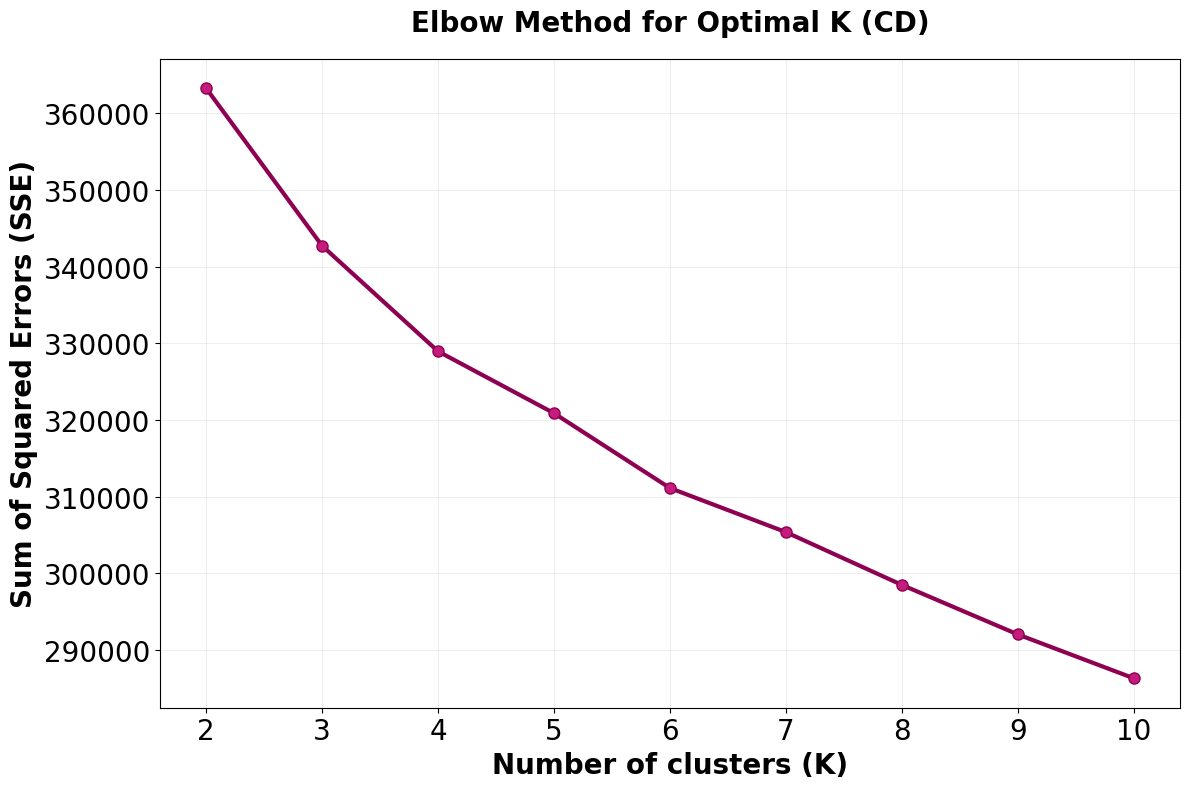

Look for an 'elbow' in the plot.
------------------------------

--- Silhouette Analysis for Optimal K (CD Subtypes) ---
Silhouette Score for K=2 (CD subtypes): 0.2910
Silhouette Score for K=3 (CD subtypes): 0.1177
Silhouette Score for K=4 (CD subtypes): 0.0868
Silhouette Score for K=5 (CD subtypes): 0.0724
Silhouette Score for K=6 (CD subtypes): 0.0697
Silhouette Score for K=7 (CD subtypes): 0.0592
Silhouette Score for K=8 (CD subtypes): 0.0567
Silhouette Score for K=9 (CD subtypes): 0.0689
Silhouette Score for K=10 (CD subtypes): 0.0500


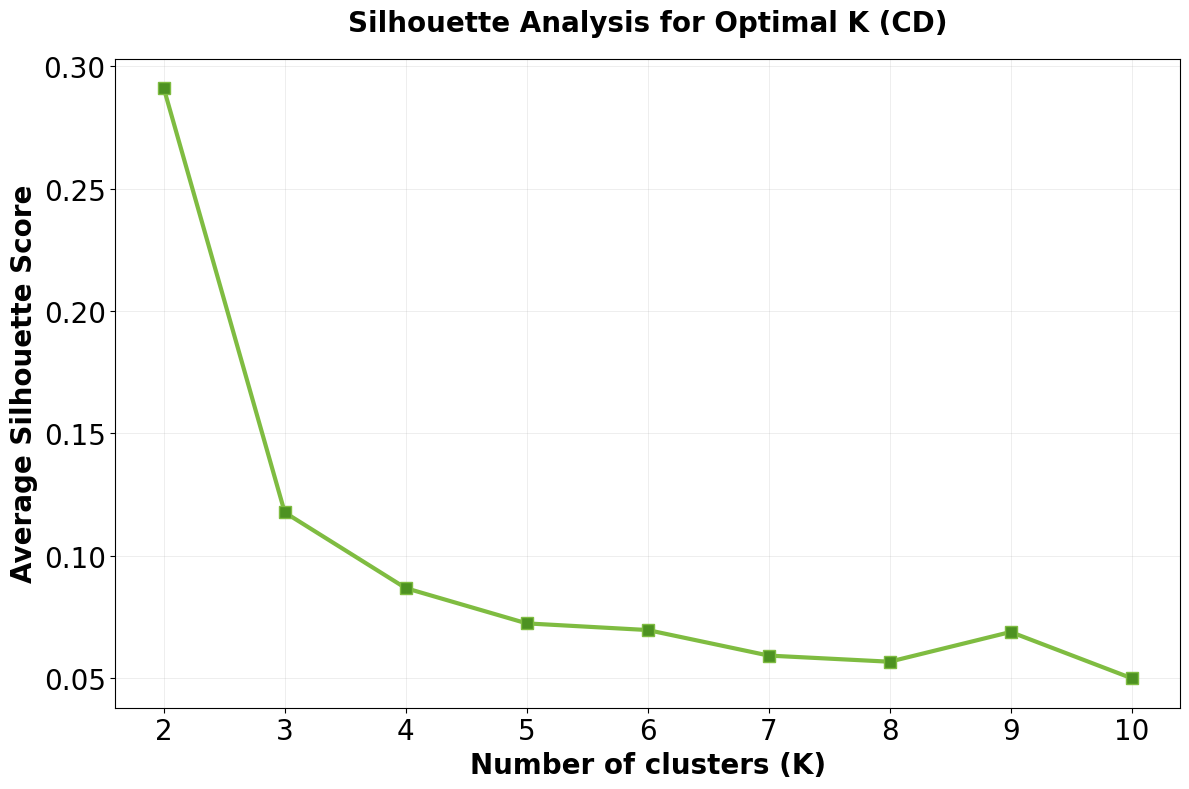

Look for the K that maximizes the Silhouette Score.
------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv' 
dataset_name_prefix = 'CD' # For context in outputs

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found.")

print(f"--- K-determination for CD Subtypes from: {file_path_reduced_data} ---")
print(f"Shape of loaded full dataset: {full_processed_df.shape}")

# --- 2. Filter for CD Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for CD patients.")
    cd_only_df = pd.DataFrame() # Empty df
else:
    cd_only_df = full_processed_df[full_processed_df['Study.Group'] == 'CD'].copy()

if cd_only_df.empty:
    print("No CD patients found in the dataset. Exiting CD subtype analysis.")
    scaled_features_cd = None
else:
    print(f"Shape of CD-only dataset: {cd_only_df.shape}")

    # --- 3. Prepare Data for Clustering (CD samples) ---
    # Feature columns - all columns except 'Sample' and 'Study.Group'
    feature_columns_cd = [col for col in cd_only_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_cd:
        print("No feature columns found in CD-only data. Exiting.")
        scaled_features_cd = None 
    else:
        print(f"Identified {len(feature_columns_cd)} feature columns for clustering CD subtypes.")
        features_for_clustering_cd = cd_only_df[feature_columns_cd].copy()

        # to check that all feature data is numeric
        for col in features_for_clustering_cd.columns: 
            features_for_clustering_cd[col] = pd.to_numeric(features_for_clustering_cd[col], errors='coerce')
        
        features_for_clustering_cd.dropna(axis=1, how='all', inplace=True) # Drop all-NaN columns
        features_for_clustering_cd.dropna(axis=0, how='all', inplace=True) # Drop all-NaN rows
        
        if features_for_clustering_cd.empty or features_for_clustering_cd.shape[1] == 0:
            print("No valid feature data remains after NaN checks for CD samples. Cannot proceed.")
            scaled_features_cd = None
        else:
            print(f"Shape of feature matrix for CD subtype clustering: {features_for_clustering_cd.shape}")
            # Scale the features
            scaler_cd = StandardScaler()
            scaled_features_cd = scaler_cd.fit_transform(features_for_clustering_cd)
            print("CD features standardized for clustering.")
            print("-" * 30)

colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

if scaled_features_cd is not None and scaled_features_cd.shape[0] > 1: # Need at least 2 samples for Kmeans
    # --- 4. Determine Optimal K using Elbow Method (for CD subtypes) ---
    print("\n--- Elbow Method for Optimal K (CD Subtypes) ---")
    sse_cd = {} 
    max_k_cd = min(11, scaled_features_cd.shape[0]) # K up to 10 or N_samples_CD-1
    k_range_cd = range(2, max_k_cd) 

    if len(k_range_cd) < 1:
        print(f"Not enough CD samples ({scaled_features_cd.shape[0]}) to test a range of K values >= 2.")
    else:
        for k in k_range_cd:
            kmeans_cd = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            kmeans_cd.fit(scaled_features_cd)
            sse_cd[k] = kmeans_cd.inertia_ 
            print(f"SSE for K={k} (CD subtypes): {sse_cd[k]:.2f}")

        plt.figure(figsize=(12, 8))
        plt.plot(list(sse_cd.keys()), list(sse_cd.values()), 
                color=colors[0], marker='o', markersize=8, linewidth=3, markerfacecolor=colors[1])
        plt.xlabel('Number of clusters (K)', fontsize=20, fontweight='semibold')
        plt.ylabel('Sum of Squared Errors (SSE)', fontsize=20, fontweight='semibold')
        plt.title(f'Elbow Method for Optimal K ({dataset_name_prefix})', fontsize=20, fontweight='semibold', pad=20)
        plt.xticks(list(k_range_cd), fontsize=20)
        plt.yticks(fontsize=20)
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        print("Look for an 'elbow' in the plot.")
    print("-" * 30)

    # --- 5. Determine Optimal K using Silhouette Analysis (for CD subtypes) ---
    print("\n--- Silhouette Analysis for Optimal K (CD Subtypes) ---")
    silhouette_scores_cd = {}
    if len(k_range_cd) < 1:
        print(f"Not enough CD samples ({scaled_features_cd.shape[0]}) for Silhouette analysis with K >= 2.")
    else:
        for k in k_range_cd: 
            kmeans_cd = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_cd = kmeans_cd.fit_predict(scaled_features_cd)
            try:
                # Ensure there's more than 1 unique label and k < n_samples for silhouette
                if len(np.unique(cluster_labels_cd)) > 1 and len(np.unique(cluster_labels_cd)) < len(scaled_features_cd):
                    silhouette_avg_cd = silhouette_score(scaled_features_cd, cluster_labels_cd)
                    silhouette_scores_cd[k] = silhouette_avg_cd
                    print(f"Silhouette Score for K={k} (CD subtypes): {silhouette_avg_cd:.4f}")
                else:
                    print(f"Could not calculate silhouette score for K={k} (CD subtypes): not enough unique clusters or samples (Unique labels: {len(np.unique(cluster_labels_cd))}, Samples: {len(scaled_features_cd)}).")
                    silhouette_scores_cd[k] = -1 # Invalid score
            except ValueError as e:
                print(f"Could not calculate silhouette score for K={k} (CD subtypes): {e}.")
                silhouette_scores_cd[k] = -1 

        plt.figure(figsize=(12, 8))
        valid_silhouette_k_cd = [k_val for k_val, score in silhouette_scores_cd.items() if score > -1] 
        valid_silhouette_v_cd = [score for k_val, score in silhouette_scores_cd.items() if score > -1]
        
        if valid_silhouette_k_cd:
            plt.plot(valid_silhouette_k_cd, valid_silhouette_v_cd, 
                    color=colors[7], marker='s', markersize=8, linewidth=3, markerfacecolor=colors[8])
            
            plt.xlabel('Number of clusters (K)', fontsize=20, fontweight='semibold')
            plt.ylabel('Average Silhouette Score', fontsize=20, fontweight='semibold')
            plt.title(f'Silhouette Analysis for Optimal K ({dataset_name_prefix})', fontsize=20, fontweight='semibold', pad=20)
            plt.xticks(valid_silhouette_k_cd, fontsize=20)
            plt.yticks(fontsize=20)
            plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            plt.tight_layout()
            plt.show()
            print("Look for the K that maximizes the Silhouette Score.")
        else:
            print("Could not plot silhouette scores as none were successfully computed for CD subtypes.")
        print("-" * 30)
else:
    print(f"K-determination for CD subtypes skipped as no valid feature data was available for CD samples.")

# UC Subtype Identification

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Load the Combined, RedUCed, and Log-Transformed Dataset ---
file_path_redUCed_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv' 
dataset_name_prefix = 'UC' # For context

try:
    full_processed_df = pd.read_csv(file_path_redUCed_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_redUCed_data} was not found.")

print(f"--- K-determination for UC Subtypes from: {file_path_redUCed_data} ---")
print(f"Shape of loaded full dataset: {full_processed_df.shape}")

# --- 2. Filter for UC Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for UC patients.")
    UC_only_df = pd.DataFrame() # Empty df
else:
    UC_only_df = full_processed_df[full_processed_df['Study.Group'] == 'UC'].copy()

if UC_only_df.empty:
    print("No UC patients found in the dataset. Exiting UC subtype analysis.")
    scaled_features_UC = None
else:
    print(f"Shape of UC-only dataset: {UC_only_df.shape}")

    # --- 3. Prepare Data for Clustering (UC samples) ---
    # Feature columns are all columns except 'Sample' and 'Study.Group'
    feature_columns_UC = [col for col in UC_only_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_UC:
        print("No feature columns found in UC-only data. Exiting.")
        scaled_features_UC = None 
    else:
        print(f"Identified {len(feature_columns_UC)} feature columns for clustering UC subtypes.")
        features_for_clustering_UC = UC_only_df[feature_columns_UC].copy()

        # Ensure all feature data is numeric
        for col in features_for_clustering_UC.columns: 
            features_for_clustering_UC[col] = pd.to_numeric(features_for_clustering_UC[col], errors='coerce')
        
        features_for_clustering_UC.dropna(axis=1, how='all', inplace=True) # Drop all-NaN columns
        features_for_clustering_UC.dropna(axis=0, how='all', inplace=True) # Drop all-NaN rows
        
        if features_for_clustering_UC.empty or features_for_clustering_UC.shape[1] == 0:
            print("No valid feature data remains after NaN checks for UC samples. Cannot proceed.")
            scaled_features_UC = None
        else:
            print(f"Shape of feature matrix for UC subtype clustering: {features_for_clustering_UC.shape}")
            # Scale the features
            scaler_UC = StandardScaler()
            scaled_features_UC = scaler_UC.fit_transform(features_for_clustering_UC)
            print("UC features standardized for clustering.")
            print("-" * 30)

if scaled_features_UC is not None and scaled_features_UC.shape[0] > 1: # Need at least 2 samples for Kmeans
    colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

    # --- 4. Determine Optimal K using Elbow Method (for UC subtypes) ---
    print("\n--- Elbow Method for Optimal K (UC Subtypes) ---")
    sse_UC = {} 
    # Adjust k_range if number of UC samples is very small, max K should be < N_samples
    max_k_UC = min(11, scaled_features_UC.shape[0]) # K up to 10 or N_samples_UC-1
    k_range_UC = range(2, max_k_UC) 

    if len(k_range_UC) < 1:
        print(f"Not enough UC samples ({scaled_features_UC.shape[0]}) to test a range of K values >= 2.")
    else:
        for k in k_range_UC:
            kmeans_UC = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            kmeans_UC.fit(scaled_features_UC)
            sse_UC[k] = kmeans_UC.inertia_ 
            print(f"SSE for K={k} (UC subtypes): {sse_UC[k]:.2f}")

        plt.figure(figsize=(12, 8))
        plt.plot(list(sse_UC.keys()), list(sse_UC.values()), 
                color=colors[1], marker='D', markersize=8, linewidth=3, markerfacecolor=colors[2])
        plt.xlabel('Number of clusters (K)', fontsize=20, fontweight='semibold')
        plt.ylabel('Sum of Squared Errors (SSE)', fontsize=20, fontweight='semibold')
        plt.title(f'Elbow Method for Optimal K ({dataset_name_prefix})', fontsize=20, fontweight='semibold', pad=20)
        plt.xticks(list(k_range_UC), fontsize=20)
        plt.yticks(fontsize=20)
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        print("Look for an 'elbow' in the plot.")
    print("-" * 30)

    # --- 5. Determine Optimal K using Silhouette Analysis (for UC subtypes) ---
    print("\n--- Silhouette Analysis for Optimal K (UC Subtypes) ---")
    silhouette_scores_UC = {}
    if len(k_range_UC) < 1:
        print(f"Not enough UC samples ({scaled_features_UC.shape[0]}) for Silhouette analysis with K >= 2.")
    else:
        for k in k_range_UC: 
            kmeans_UC = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_UC = kmeans_UC.fit_predict(scaled_features_UC)
            try:
                # Ensure there's more than 1 unique label and k < n_samples for silhouette
                if len(np.unique(cluster_labels_UC)) > 1 and len(np.unique(cluster_labels_UC)) < len(scaled_features_UC):
                    silhouette_avg_UC = silhouette_score(scaled_features_UC, cluster_labels_UC)
                    silhouette_scores_UC[k] = silhouette_avg_UC
                    print(f"Silhouette Score for K={k} (UC subtypes): {silhouette_avg_UC:.4f}")
                else:
                    print(f"Could not calculate silhouette score for K={k} (UC subtypes): not enough unique clusters or samples (Unique labels: {len(np.unique(cluster_labels_UC))}, Samples: {len(scaled_features_UC)}).")
                    silhouette_scores_UC[k] = -1 # Invalid score
            except ValueError as e:
                print(f"Could not calculate silhouette score for K={k} (UC subtypes): {e}.")
                silhouette_scores_UC[k] = -1 

        plt.figure(figsize=(12, 8))
        valid_silhouette_k_UC = [k_val for k_val, score in silhouette_scores_UC.items() if score > -1] 
        valid_silhouette_v_UC = [score for k_val, score in silhouette_scores_UC.items() if score > -1]
        
        if valid_silhouette_k_UC:
            plt.plot(valid_silhouette_k_UC, valid_silhouette_v_UC, 
                    color=colors[6], marker='^', markersize=8, linewidth=3, markerfacecolor=colors[7])
            plt.xlabel('Number of clusters (K)', fontsize=20, fontweight='semibold')
            plt.ylabel('Average Silhouette Score', fontsize=20, fontweight='semibold')
            plt.title(f'Silhouette Analysis for Optimal K ({dataset_name_prefix})', fontsize=20, fontweight='semibold', pad=20)
            plt.xticks(valid_silhouette_k_UC, fontsize=20)
            plt.yticks(fontsize=20)
            plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            plt.tight_layout()
            plt.show()
            print("Look for the K that maximizes the Silhouette Score.")
        else:
            print("Could not plot silhouette scores as none were successfully computed for UC subtypes.")
    print("-" * 30)
else:
    print(f"K-determination for UC subtypes skipped as no valid feature data was available for UC samples.")

--- K-determination for UC Subtypes from: processing_data/filtered_log_transformed_mtb_overlap.tsv ---
Shape of loaded full dataset: (352, 3295)
Shape of UC-only dataset: (96, 3295)
Identified 3293 feature columns for clustering UC subtypes.
Shape of feature matrix for UC subtype clustering: (96, 3293)
UC features standardized for clustering.
------------------------------

--- Elbow Method for Optimal K (UC Subtypes) ---
SSE for K=2 (UC subtypes): 232682.53
SSE for K=3 (UC subtypes): 218080.09
SSE for K=4 (UC subtypes): 207995.17
SSE for K=5 (UC subtypes): 199656.12
SSE for K=6 (UC subtypes): 193117.17
SSE for K=7 (UC subtypes): 186648.60
SSE for K=8 (UC subtypes): 177026.69
SSE for K=9 (UC subtypes): 172575.91
SSE for K=10 (UC subtypes): 167801.53


Look for an 'elbow' in the plot.
------------------------------

--- Silhouette Analysis for Optimal K (UC Subtypes) ---
Silhouette Score for K=2 (UC subtypes): 0.2506
Silhouette Score for K=3 (UC subtypes): 0.1389
Silhouette Score for K=4 (UC subtypes): 0.1061
Silhouette Score for K=5 (UC subtypes): 0.0724
Silhouette Score for K=6 (UC subtypes): 0.0845
Silhouette Score for K=7 (UC subtypes): 0.0680
Silhouette Score for K=8 (UC subtypes): 0.0854
Silhouette Score for K=9 (UC subtypes): 0.0880
Silhouette Score for K=10 (UC subtypes): 0.0938


Look for the K that maximizes the Silhouette Score.
------------------------------


# CD - K-Means and Hierarchical Clustering

Successfully loaded data from: processing_data/filtered_log_transformed_mtb_overlap.tsv
--- K-means & Hierarchical Clustering for CD Subtypes ---
Shape of CD-only dataset: (155, 3295)
Using 3293 features for clustering 155 CD samples.
------------------------------

--- Applying K-means with K = 2 for CD Subtypes ---
Silhouette Score for K-means K=2 (CD subtypes): 0.2910
------------------------------

--- CD Subtype K-means Cluster Characterization ---
Value counts for K-means CD Subtype Clusters (K=2):
KMeans_Cluster
0    108
1     47
Name: count, dtype: int64
------------------------------

--- Visualizing CD Subtype K-means Clusters with PCA ---


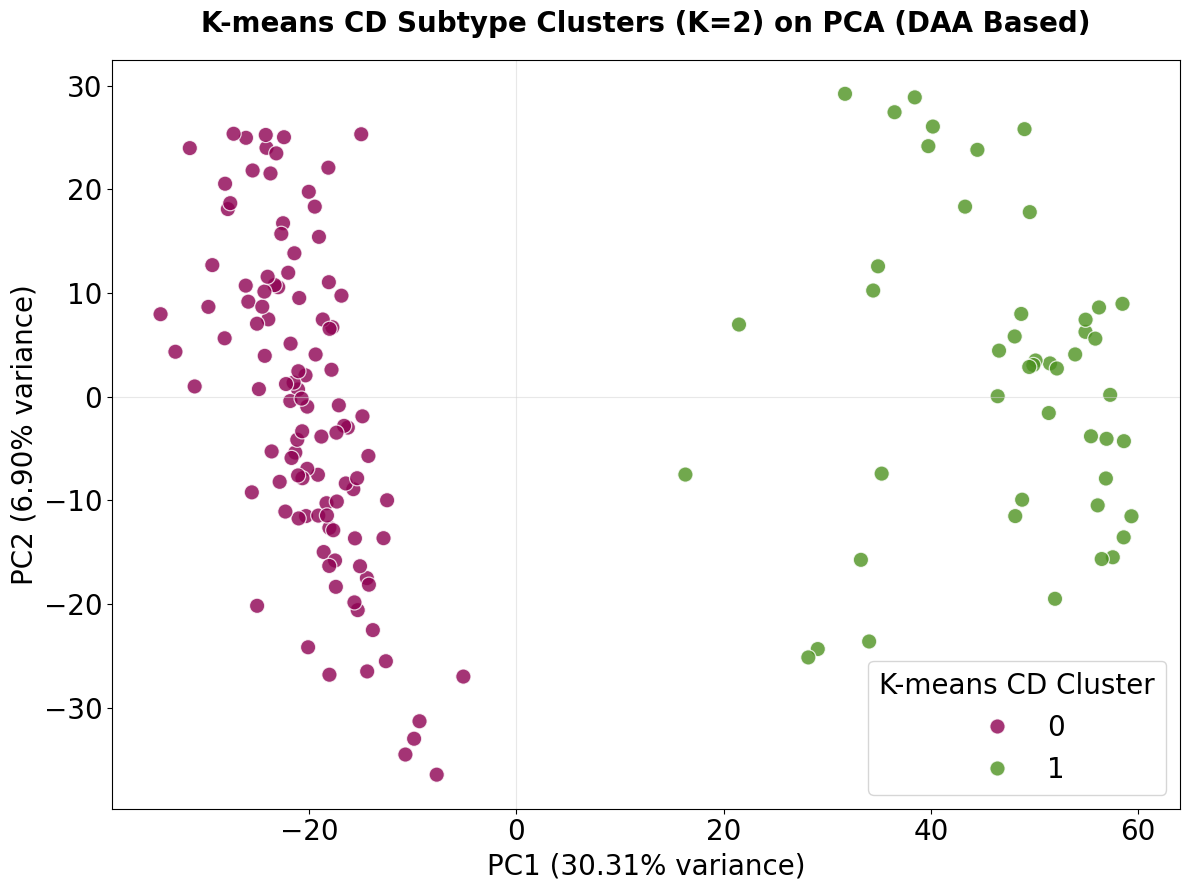

------------------------------
Saved CD data with K-means cluster labels to processing_data/CD_kmeans_clustered_data_not_borut_k2.tsv
------------------------------

--- Hierarchical Clustering for CD Subtypes ---
Performing hierarchical clustering using 'ward' linkage and 'euclidean' metric...


Cutting dendrogram to obtain 2 clusters...

--- CD Subtype Hierarchical Cluster Characterization ---
Value counts for Hierarchical CD Subtype Clusters (K=2):
Hierarchical_Cluster
1     47
2    108
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (K=2, CD): 0.2910
------------------------------

--- Visualizing CD Subtype Hierarchical Clusters with PCA ---


------------------------------

--- Generating Clustermap for CD Subtypes (Hierarchical Clustering) ---
Generating clustermap with 155 samples and 3293 features.


------------------------------
Saved CD data with Hierarchical cluster labels to processing_data/CD_hierarchical_clustered_data_not_boruta_k2.tsv
------------------------------

--- Analysis complete for CD ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# --- Libraries for Hierarchical Clustering ---
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.patches import Patch # For custom legends in clustermap

colors = ['#8e0152', '#4d9221']  # Dark pink and dark green

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv'
dataset_name_prefix = 'CD'

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
    print(f"Successfully loaded data from: {file_path_reduced_data}")
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found. Exiting.")
    exit()

print(f"--- K-means & Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

# --- 2. Filter for Specific Patient Group (e.g., CD Patients Only) ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for patient group.")
    specific_group_df = pd.DataFrame()
else:
    # This makes the script flexible for 'CD' or 'UC' by changing dataset_name_prefix
    specific_group_df = full_processed_df[full_processed_df['Study.Group'] == dataset_name_prefix].copy()

if specific_group_df.empty or len(specific_group_df) < 2 : # Need at least 2 samples for clustering
    print(f"Not enough {dataset_name_prefix} patients found or remaining for subtype analysis (found {len(specific_group_df)}). Exiting.")
    scaled_features_group = None
else:
    print(f"Shape of {dataset_name_prefix}-only dataset: {specific_group_df.shape}")
    feature_columns_group = [col for col in specific_group_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_group:
        print(f"No feature columns found in {dataset_name_prefix}-only data.")
        scaled_features_group = None
    else:
        # This df holds the original (log-transformed, Boruta-selected) feature values for the group
        features_for_clustering_group = specific_group_df[feature_columns_group].copy()
        
        # Ensure all feature data is numeric (it should be, but again, good check)
        for col in features_for_clustering_group.columns:
            features_for_clustering_group[col] = pd.to_numeric(features_for_clustering_group[col], errors='coerce')
        
        # Drop columns/rows that might have become all NaNs after coercion (unlikely with prior processing)
        features_for_clustering_group.dropna(axis=1, how='all', inplace=True)
        # Keep track of original indices to align 'Sample' IDs later
        original_indices_group = features_for_clustering_group.index 
        features_for_clustering_group.dropna(axis=0, how='any', inplace=True) # Drop rows with any NaNs in features
        
        # Align the specific_group_df (metadata) to match exactly the rows used for clustering
        # This df contains 'Sample', 'Study.Group' and will store cluster labels
        group_df_aligned = specific_group_df.loc[features_for_clustering_group.index].copy()

        if features_for_clustering_group.empty or features_for_clustering_group.shape[1] == 0:
            print(f"No valid feature data remains after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        elif features_for_clustering_group.shape[0] < 2:
            print(f"Not enough samples ({features_for_clustering_group.shape[0]}) remaining after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        else:
            scaler_group = StandardScaler()
            scaled_features_group = scaler_group.fit_transform(features_for_clustering_group)
            print(f"Using {scaled_features_group.shape[1]} features for clustering {scaled_features_group.shape[0]} {dataset_name_prefix} samples.")
            print("-" * 30)

# Proceed only if we have valid scaled features for the group
if scaled_features_group is not None and scaled_features_group.shape[0] > 1:

    # --- 3. Apply K-means Clustering (as per the k-number determined in the previous code block) ---
    chosen_k_kmeans = 2
    
    if chosen_k_kmeans >= scaled_features_group.shape[0]:
        print(f"Warning: chosen_k_kmeans ({chosen_k_kmeans}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K.")    
    print(f"\n--- Applying K-means with K = {chosen_k_kmeans} for {dataset_name_prefix} Subtypes ---")
    kmeans_group = KMeans(n_clusters=chosen_k_kmeans, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
    cluster_labels_kmeans_group = kmeans_group.fit_predict(scaled_features_group)

    # Add K-means cluster labels to the aligned group DataFrame
    group_clustered_df_kmeans = group_df_aligned.copy()
    group_clustered_df_kmeans['KMeans_Cluster'] = cluster_labels_kmeans_group
    
    try:
        # Silhouette score requires at least 2 clusters and less clusters than samples.
        if 1 < len(np.unique(cluster_labels_kmeans_group)) < scaled_features_group.shape[0]:
            current_silhouette_score_kmeans = silhouette_score(scaled_features_group, cluster_labels_kmeans_group)
            print(f"Silhouette Score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {current_silhouette_score_kmeans:.4f}")
        else:
            print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): "
                  f"Number of unique labels ({len(np.unique(cluster_labels_kmeans_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
    except ValueError as e:
         print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {e}")
    print("-" * 30)

    # --- 4. Characterize K-means Clusters Numerically ---
    print(f"\n--- {dataset_name_prefix} Subtype K-means Cluster Characterization ---")
    print(f"Value counts for K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}):")
    print(group_clustered_df_kmeans['KMeans_Cluster'].value_counts().sort_index())
    print("-" * 30)

    # --- 5. Visualize K-means Clusters using PCA ---
    print(f"\n--- Visualizing {dataset_name_prefix} Subtype K-means Clusters with PCA ---")
    if scaled_features_group.shape[1] >= 2 and scaled_features_group.shape[0] >= 2:
        pca_for_group_viz = PCA(n_components=2, random_state=42)
        principal_components_group_viz = pca_for_group_viz.fit_transform(scaled_features_group)
        
        pca_group_viz_df = pd.DataFrame(
            data=principal_components_group_viz,
            columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
            index=group_clustered_df_kmeans.index # Use index from the clustered_df for proper alignment
        )
        
        # Combine PCA results with KMeans_Cluster labels and Sample IDs
        pca_group_viz_df = pd.concat([pca_group_viz_df, group_clustered_df_kmeans[['Sample', 'KMeans_Cluster']]], axis=1)

        plt.figure(figsize=(12, 9))
        sns.scatterplot(
            x=f'PC1_{dataset_name_prefix}_Subtype',
            y=f'PC2_{dataset_name_prefix}_Subtype',
            hue='KMeans_Cluster',
            palette=(colors * (chosen_k_kmeans // 2 + 1))[:chosen_k_kmeans], # Cycle through dark pink and green
            data=pca_group_viz_df,
            s=120,
            alpha=0.8
        )
        plt.title(f'K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}) on PCA (DAA Based)', 
                  fontsize=20, fontweight='semibold', pad=20)
        plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                   fontsize=20, fontweight='regular')
        plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                   fontsize=20, fontweight='regular')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(title=f'K-means {dataset_name_prefix} Cluster', fontsize=20, title_fontsize=20)
        legend.set_title(f'K-means {dataset_name_prefix} Cluster', prop={'size': 20, 'weight': 'regular'})
        plt.grid(False)
        plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough features/samples for PCA plot for {dataset_name_prefix} K-means subtypes.")
    print("-" * 30)

    # --- Save K-means clustered data ---
    output_filename_kmeans = f'processing_data/{dataset_name_prefix}_kmeans_clustered_data_not_boruta_k2.tsv'
    group_clustered_df_kmeans.to_csv(output_filename_kmeans, sep='\t', index=False)
    print(f"Saved {dataset_name_prefix} data with K-means cluster labels to {output_filename_kmeans}")
    print("-" * 30)


    ###########################################################################
    # --- Hierarchical Clustering for CD Subtypes ---
    ###########################################################################
    print(f"\n--- Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

    # --- 6. Perform Hierarchical Clustering ---
    linkage_method = 'ward'  # Minimizes variance within clusters, good for general purpose
    metric = 'euclidean'     # Standard for scaled data with 'ward'

    print(f"Performing hierarchical clustering using '{linkage_method}' linkage and '{metric}' metric...")
    # `scaled_features_group` is the Z-scaled feature matrix for CD patients
    linked_matrix = linkage(scaled_features_group, method=linkage_method, metric=metric)

    # --- 7. Dendrogram ---
    plt.figure(figsize=(16, 10))
    dendrogram(linked_matrix,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               truncate_mode=None,
               color_threshold=0.7*max(linked_matrix[:,2]),
               above_threshold_color=colors[0]) # Uses dark pink for branches above threshold
    plt.title(f'Hierarchical Clustering Dendrogram for {dataset_name_prefix} Patients ({linkage_method} linkage)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xlabel("Sample Index / Cluster", fontsize=20, fontweight='semibold')
    plt.ylabel(f"Distance ({metric})", fontsize=20, fontweight='semibold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # --- 8. Determine Clusters from Dendrogram & Assign Labels ---
    num_clusters_hc = chosen_k_kmeans
    
    if num_clusters_hc >= scaled_features_group.shape[0] :
        print(f"Warning: num_clusters_hc ({num_clusters_hc}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K_hc.")
        if scaled_features_group.shape[0] > 1:
            num_clusters_hc = max(2, scaled_features_group.shape[0] -1)
            print(f"Adjusted num_clusters_hc to {num_clusters_hc}")
        else: # Should not happen due to earlier checks, but defensive
             print(f"Cannot perform hierarchical clustering with {scaled_features_group.shape[0]} samples.")
             # Skip further HC steps if this edge case is hit
             num_clusters_hc = 0


    if num_clusters_hc > 0: # Proceed if num_clusters_hc is valid
        print(f"Cutting dendrogram to obtain {num_clusters_hc} clusters...")
        cluster_labels_hc_group = fcluster(linked_matrix, num_clusters_hc, criterion='maxclust')

        # Add Hierarchical Cluster labels to a new DataFrame
        group_clustered_df_hc = group_df_aligned.copy() # ensures the same aligned group data
        group_clustered_df_hc['Hierarchical_Cluster'] = cluster_labels_hc_group
        
        # --- 9. Characterize Hierarchical Clusters ---
        print(f"\n--- {dataset_name_prefix} Subtype Hierarchical Cluster Characterization ---")
        print(f"Value counts for Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}):")
        print(group_clustered_df_hc['Hierarchical_Cluster'].value_counts().sort_index())

        try:
            if 1 < len(np.unique(cluster_labels_hc_group)) < scaled_features_group.shape[0]:
                silhouette_avg_hc = silhouette_score(scaled_features_group, cluster_labels_hc_group)
                print(f"Silhouette Score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {silhouette_avg_hc:.4f}")
            else:
                print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): "
                      f"Number of unique labels ({len(np.unique(cluster_labels_hc_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
        except ValueError as e:
            print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {e}")
        print("-" * 30)

        # --- 10. Visualize Hierarchical Clusters using PCA (for comparison with K-means) ---
        print(f"\n--- Visualizing {dataset_name_prefix} Subtype Hierarchical Clusters with PCA ---")
        if 'pca_for_group_viz' in locals() and pca_for_group_viz is not None:
            pca_group_viz_df_hc = pd.DataFrame(
                data=principal_components_group_viz,
                columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
                index=group_clustered_df_hc.index
            )
            pca_group_viz_df_hc = pd.concat([pca_group_viz_df_hc, group_clustered_df_hc[['Sample', 'Hierarchical_Cluster']]], axis=1)

            plt.figure(figsize=(12, 9))
            sns.scatterplot(
                x=f'PC1_{dataset_name_prefix}_Subtype',
                y=f'PC2_{dataset_name_prefix}_Subtype',
                hue='Hierarchical_Cluster',
                palette=(colors * (num_clusters_hc // 2 + 1))[:num_clusters_hc],
                data=pca_group_viz_df_hc,
                s=120,
                alpha=0.8
            )
            plt.title(f'Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}) on PCA', 
                      fontsize=20, fontweight='semibold', pad=20)
            plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                       fontsize=20, fontweight='regular')
            plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                       fontsize=20, fontweight='regular')
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            legend = plt.legend(title=f'Hierarchical {dataset_name_prefix} Cluster', fontsize=20, title_fontsize=20)
            legend.set_title(f'Hierarchical {dataset_name_prefix} Cluster', prop={'size': 20, 'weight': 'regular'})
            plt.grid(False)
            plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"PCA components not available for visualizing Hierarchical clusters for {dataset_name_prefix}.")
        print("-" * 30)

        # --- 11. Visualize with Clustermap (Heatmap with Dendrograms) ---
        print(f"\n--- Generating Clustermap for {dataset_name_prefix} Subtypes (Hierarchical Clustering) ---")
        
        data_for_heatmap_group = features_for_clustering_group.copy()
        # Set Sample IDs as index ...if they are not already (for labeling heatmap rows)
        if 'Sample' in group_df_aligned.columns:
             data_for_heatmap_group.index = group_df_aligned['Sample']
        
        # Creates a Series for row colors based on hierarchical cluster, indexed by Sample ID
        cluster_series_hc = group_clustered_df_hc.set_index('Sample')['Hierarchical_Cluster']
        
        unique_hc_clusters = sorted(cluster_series_hc.unique())
        palette_hc_map = (colors * (len(unique_hc_clusters) // 2 + 1))[:len(unique_hc_clusters)]
        cluster_color_map_hc = {cluster_val: color for cluster_val, color in zip(unique_hc_clusters, palette_hc_map)}
        row_colors_hc_mapped = cluster_series_hc.map(cluster_color_map_hc)
        
        # Ensure row_colors_hc_mapped is aligned with data_for_heatmap_group
        if not data_for_heatmap_group.index.equals(row_colors_hc_mapped.index):
            print("Warning: Index mismatch between heatmap data and row colors. Attempting to align.")
            try:
                row_colors_hc_mapped = row_colors_hc_mapped.reindex(data_for_heatmap_group.index)
            except Exception as e:
                print(f"Could not align row_colors with heatmap data: {e}. Clustermap might not have row colors.")


        if data_for_heatmap_group.shape[0] > 1 and data_for_heatmap_group.shape[1] > 1:
            print(f"Generating clustermap with {data_for_heatmap_group.shape[0]} samples and {data_for_heatmap_group.shape[1]} features.")
            try:
                g = sns.clustermap(
                    data_for_heatmap_group,      # Original selected features (log-transformed)
                    row_linkage=linked_matrix,   # Use pre-computed linkage for rows (samples)
                    cmap="viridis",              # Colormap for the heatmap values
                    standard_scale=1,            # Z-score features (columns) for visualization
                    row_colors=row_colors_hc_mapped if not row_colors_hc_mapped.isnull().all() else None, # Assign colors to rows based on HC
                    figsize=(min(30, 0.8 * data_for_heatmap_group.shape[1]), # Width based on num features
                             min(30, 0.4 * data_for_heatmap_group.shape[0] + 5)), # Height based on num samples
                    dendrogram_ratio=(.1, .2)
                )
                g.fig.suptitle(f'Hierarchical Clustering of {dataset_name_prefix} Patient Metabolites (K={num_clusters_hc}, {linkage_method} linkage)', y=1.03, fontsize=16)
                
                if not row_colors_hc_mapped.isnull().all():
                    handles = [Patch(facecolor=cluster_color_map_hc[name]) for name in unique_hc_clusters if name in cluster_color_map_hc]
                    if handles: # only add legend if there are handles
                        legend_title = f'HC ({dataset_name_prefix})'
                        g.ax_heatmap.legend(handles, unique_hc_clusters, title=legend_title,
                                            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.show()
            except Exception as e:
                print(f"Error generating clustermap: {e}")
                print("This can happen if there are too few samples/features or issues with linkage/data.")

        else:
            print(f"Not enough samples or features for Clustermap for {dataset_name_prefix} subtypes.")
        print("-" * 30)

        # --- 12. Save DataFrame with Hierarchical Cluster labels ---
        output_filename_hc = f'processing_data/{dataset_name_prefix}_hierarchical_clustered_data_not_boruta_k2.tsv'
        group_clustered_df_hc.to_csv(output_filename_hc, sep='\t', index=False)
        print(f"Saved {dataset_name_prefix} data with Hierarchical cluster labels to {output_filename_hc}")
        print("-" * 30)
    else:
        print(f"Hierarchical clustering skipped for {dataset_name_prefix} due to invalid number of clusters ({num_clusters_hc}).")


else:
    print(f"K-means and Hierarchical clustering for {dataset_name_prefix} subtypes skipped as no valid feature data was available or insufficient samples.")

print(f"\n--- Analysis complete for {dataset_name_prefix} ---")

CD - DAA with k=2

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv' 
dataset_name_script = 'CD_K2_DAA' # Context for DAA file names
chosen_k_cd = 2

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found.")
else:
    if 'Study.Group' not in full_processed_df.columns:
        print("Error: 'Study.Group' column not found in loaded data. Cannot filter for CD patients.")
        cd_only_df = pd.DataFrame() 
    else:
        cd_only_df = full_processed_df[full_processed_df['Study.Group'] == 'CD'].copy()

print(f"--- Corrected K-means for CD Subtype Clusters (K={chosen_k_cd}) & Saving ---")

if cd_only_df.empty or len(cd_only_df) < chosen_k_cd : 
    print(f"Not enough CD patients found ({len(cd_only_df)}) or remaining for K={chosen_k_cd} subtype analysis. Exiting.")
else:
    print(f"Shape of CD-only dataset: {cd_only_df.shape}")
    feature_columns_cd = [col for col in cd_only_df.columns if col not in ['Sample', 'Study.Group']] 

    if not feature_columns_cd:
        print("No feature columns found for clustering.")
    else:
        features_for_clustering_cd = cd_only_df[feature_columns_cd].copy()
        for col in features_for_clustering_cd.columns: 
            features_for_clustering_cd[col] = pd.to_numeric(features_for_clustering_cd[col], errors='coerce')
        
        features_for_clustering_cd.dropna(axis=1, how='all', inplace=True)
        original_indices_cd = features_for_clustering_cd.index 
        features_for_clustering_cd.dropna(axis=0, how='all', inplace=True)
        cd_only_df_aligned = cd_only_df.loc[features_for_clustering_cd.index] # Align original CD data
        
        current_cd_feature_list_for_daa = features_for_clustering_cd.columns.tolist()

        if features_for_clustering_cd.empty:
            print("No valid CD feature data for clustering.")
        else:
            scaler_cd = StandardScaler()
            scaled_features_cd = scaler_cd.fit_transform(features_for_clustering_cd)
            kmeans_cd = KMeans(n_clusters=chosen_k_cd, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_cd = kmeans_cd.fit_predict(scaled_features_cd)
            # the DataFrame that contains the original CD data aligned with clustering input
            cd_clustered_df = cd_only_df_aligned.copy()
            # Define the cluster column name
            cd_cluster_col_name = f'KMeans_Cluster_CD_K{chosen_k_cd}' # will be 'KMeans_Cluster_CD_K2'
            cd_clustered_df[cd_cluster_col_name] = cluster_labels_cd
            os.makedirs('processing_data/cd_clusters', exist_ok=True)
            output_clustered_filename = 'processing_data/cd_clusters/cd_clustered_df_k2.tsv' # the file for visualizations
            cd_clustered_df.to_csv(output_clustered_filename, sep='\t', index=False)
            
            print(f"\nK-means clustering (K={chosen_k_cd}) for CD samples complete.")
            print(f"DataFrame with CD samples and K={chosen_k_cd} cluster labels saved to: {output_clustered_filename}")
            print("CD Subtype Cluster sizes based on this run:")
            print(cd_clustered_df[cd_cluster_col_name].value_counts().sort_index())
            print("\nContents of the saved file (first 5 rows):")
            print(pd.read_csv(output_clustered_filename, sep='\t').head())
            print(f"\nMake sure the column '{cd_cluster_col_name}' is present in the saved file.")
            print("-" * 30)

            # --- 3. Define DAA Function (same as before) ---
            def perform_cluster_daa(df, features_list, cluster_col_name, cluster1_label, cluster2_label, top_n=20):
                print(f"\n--- DAA: CD Subtype Cluster {cluster1_label} vs Cluster {cluster2_label} ---")
                group1_df = df[df[cluster_col_name] == cluster1_label]
                group2_df = df[df[cluster_col_name] == cluster2_label]

                if len(group1_df) < 2 or len(group2_df) < 2:
                    print(f"Not enough samples for DAA between C{cluster1_label} ({len(group1_df)}) and C{cluster2_label} ({len(group2_df)}).")
                    return pd.DataFrame(), pd.DataFrame() 

                group1_features = group1_df[features_list]
                group2_features = group2_df[features_list]
                
                cluster_results = []
                for feature in features_list:
                    g1_vals = group1_features[feature].dropna()
                    g2_vals = group2_features[feature].dropna()
                    if len(g1_vals) < 2 or len(g2_vals) < 2: continue
                    
                    t_stat, p_value = stats.ttest_ind(g1_vals, g2_vals, equal_var=False, nan_policy='omit')
                    mean_g1_log = np.mean(g1_vals); mean_g2_log = np.mean(g2_vals)
                    log2_fc = mean_g1_log - mean_g2_log
                    mean_g1_orig = np.mean(np.expm1(g1_vals)); mean_g2_orig = np.mean(np.expm1(g2_vals))
                    fold_change_orig = np.nan
                    if pd.notna(mean_g2_orig) and mean_g2_orig != 0 and pd.notna(mean_g1_orig):
                        fold_change_orig = mean_g1_orig / mean_g2_orig
                    
                    cluster_results.append({
                        'Feature': feature, 'P_Value': p_value,
                        f'Mean_Log_CD_C{cluster1_label}': mean_g1_log, f'Mean_Log_CD_C{cluster2_label}': mean_g2_log,
                        'Log2_Fold_Change_on_LogData': log2_fc, 
                        'Fold_Change_OrigScale': fold_change_orig
                    })
                
                results_df = pd.DataFrame(cluster_results)
                if results_df.empty or 'P_Value' not in results_df.columns or results_df['P_Value'].isnull().all():
                    print("No valid P_Values for this comparison."); return pd.DataFrame(), pd.DataFrame()
                results_df.dropna(subset=['P_Value'], inplace=True)
                if results_df.empty: print("No results after P_Value NaN drop."); return pd.DataFrame(), pd.DataFrame()

                reject, pvals_corrected, _, _ = multipletests(results_df['P_Value'], method='fdr_bh')
                results_df['Adjusted_P_Value'] = pvals_corrected
                results_df = results_df.sort_values(by='Adjusted_P_Value')
                
                significant_hits = results_df[results_df['Adjusted_P_Value'] < 0.05]
                print(f"Top {top_n} differentiating features between CD Subtype Cluster {cluster1_label} and Cluster {cluster2_label} (FDR < 0.05):")
                print(significant_hits[['Feature', 'Adjusted_P_Value', 'Log2_Fold_Change_on_LogData', 'Fold_Change_OrigScale']].head(top_n))
                print(f"Found {len(significant_hits)} significant features for CD Subtype Cluster {cluster1_label} vs {cluster2_label} at FDR < 0.05.")
                return results_df, significant_hits

            # --- 4. Perform Pairwise DAA Between K=2 CD Subtype Clusters ---
            if not cd_clustered_df.empty and cd_cluster_col_name in cd_clustered_df.columns:
                print(f"\nStarting DAA for K={chosen_k_cd} CD Subtype clusters.")
                # For K=2, we only have one comparison: Cluster 0 vs Cluster 1
                daa_CD_C0_vs_C1_all, daa_CD_C0_vs_C1_sig = perform_cluster_daa(cd_clustered_df, current_cd_feature_list_for_daa, cd_cluster_col_name, 0, 1, top_n=20)
                print("-" * 30)
                print("DAA between CD Subtype clusters complete.")
                if not daa_CD_C0_vs_C1_sig.empty: 
                    daa_CD_C0_vs_C1_sig.to_csv(f'processing_data/cd_clusters/DAA_sig_{dataset_name_script}_C0vC1.tsv', sep='\t', index=False)
            else:
                print("Clustered CD DataFrame is empty or missing cluster labels. Cannot perform DAA.")

--- Corrected K-means for CD Subtype Clusters (K=2) & Saving ---
Shape of CD-only dataset: (155, 3295)

K-means clustering (K=2) for CD samples complete.
DataFrame with CD samples and K=2 cluster labels saved to: processing_data/cd_clusters/cd_clustered_df_k2.tsv
CD Subtype Cluster sizes based on this run:
KMeans_Cluster_CD_K2
0    108
1     47
Name: count, dtype: int64

Contents of the saved file (first 5 rows):
     Sample Study.Group  C18n_QI56__glycochenodeoxycholate  \
0  MSM5LLDS          CD                          13.837751   
1  ESM5MEBE          CD                          13.513575   
2  MSM6J2IQ          CD                          13.431240   
3  HSM5MD62          CD                          13.149229   
4  CSM5MCVN          CD                          14.102433   

   C18n_QI66__salicylate  C18n_QI1577__NA  C18n_QI2961__NA  C18n_QI3444__NA  \
0              11.360473         9.424645        10.447003        10.751521   
1              10.161535         7.698936        10.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Top 20 differentiating features between CD Subtype Cluster 0 and Cluster 1 (FDR < 0.05):
              Feature  Adjusted_P_Value  Log2_Fold_Change_on_LogData  \
2669  HILp_QI1201__NA      4.163576e-97                   -11.001478   
530    C18n_QI946__NA      1.381812e-95                    -7.169045   
147   C18n_QI1054__NA      1.390081e-94                    -7.532256   
2160  HILn_QI1804__NA      1.111746e-93                   -10.141906   
283   C18n_QI1744__NA      8.135850e-90                    -9.865794   
2434  HILp_QI9441__NA      9.599764e-90                   -10.390969   
1949  HILn_QI1296__NA      6.139723e-89                   -12.127203   
516    C18n_QI944__NA      6.139723e-89                    -6.936177   
200   C18n_QI3635__NA      2.436843e-88                    -8.453168   
2679  HILp_QI2095__NA      9.896251e-88                   -10.610471   
419   C18n_QI4450__NA      1.420069e-86                    -8.902152   
1947  HILn_QI2242__NA      2.278908e-86        

# UC - K-Means and Hierarchical Clustering

Successfully loaded data from: processing_data/filtered_log_transformed_mtb_overlap.tsv
--- K-means & Hierarchical Clustering for UC Subtypes ---
Shape of UC-only dataset: (96, 3295)
Using 3293 features for clustering 96 UC samples.
------------------------------

--- Applying K-means with K = 2 for UC Subtypes ---
Silhouette Score for K-means K=2 (UC subtypes): 0.2506
------------------------------

--- UC Subtype K-means Cluster Characterization ---
Value counts for K-means UC Subtype Clusters (K=2):
KMeans_Cluster
0    65
1    31
Name: count, dtype: int64
------------------------------

--- Visualizing UC Subtype K-means Clusters with PCA ---


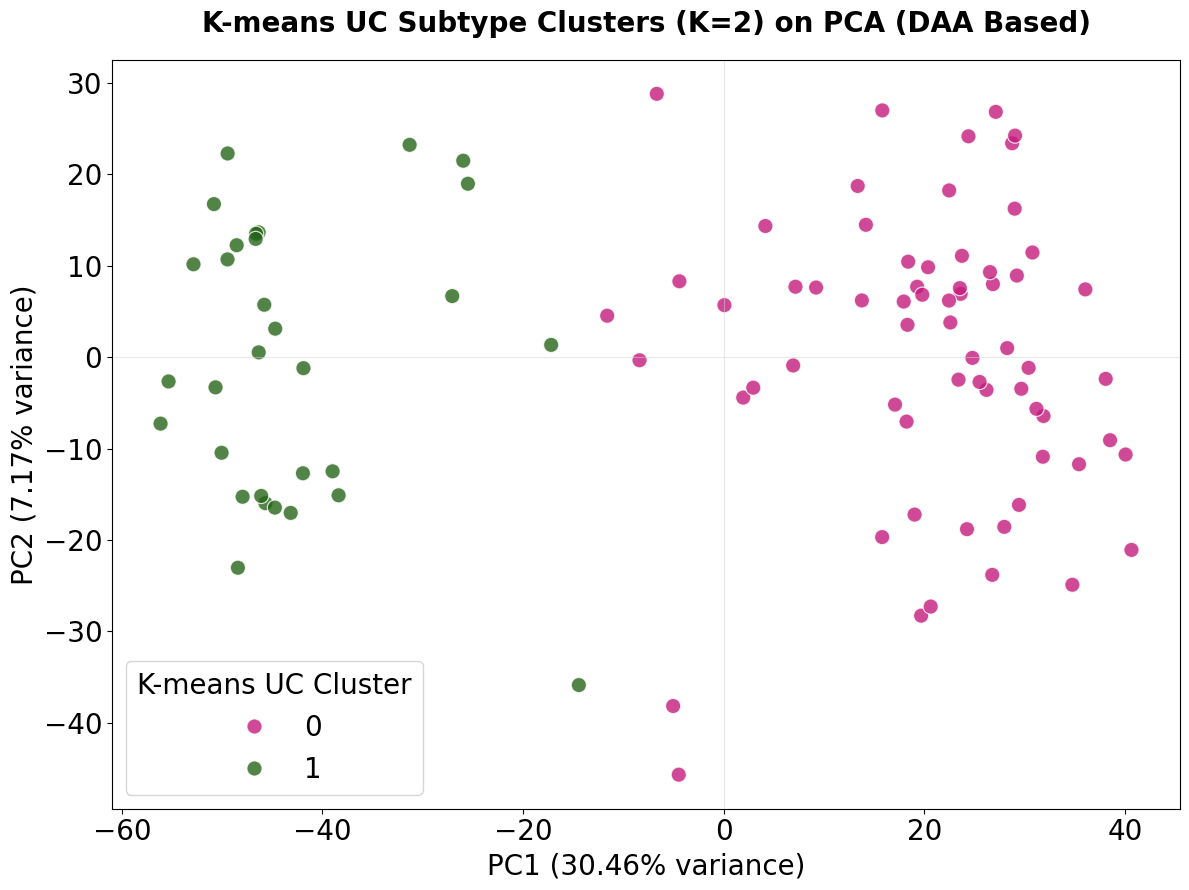

------------------------------
Saved UC data with K-means cluster labels to processing_data/UC_kmeans_clustered_data_not_borut_k2.tsv
------------------------------

--- Hierarchical Clustering for UC Subtypes ---
Performing hierarchical clustering using 'ward' linkage and 'euclidean' metric...


Cutting dendrogram to obtain 2 clusters...

--- UC Subtype Hierarchical Cluster Characterization ---
Value counts for Hierarchical UC Subtype Clusters (K=2):
Hierarchical_Cluster
1    53
2    43
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (K=2, UC): 0.2070
------------------------------

--- Visualizing UC Subtype Hierarchical Clusters with PCA ---


------------------------------

--- Generating Clustermap for UC Subtypes (Hierarchical Clustering) ---
Generating clustermap with 96 samples and 3293 features.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


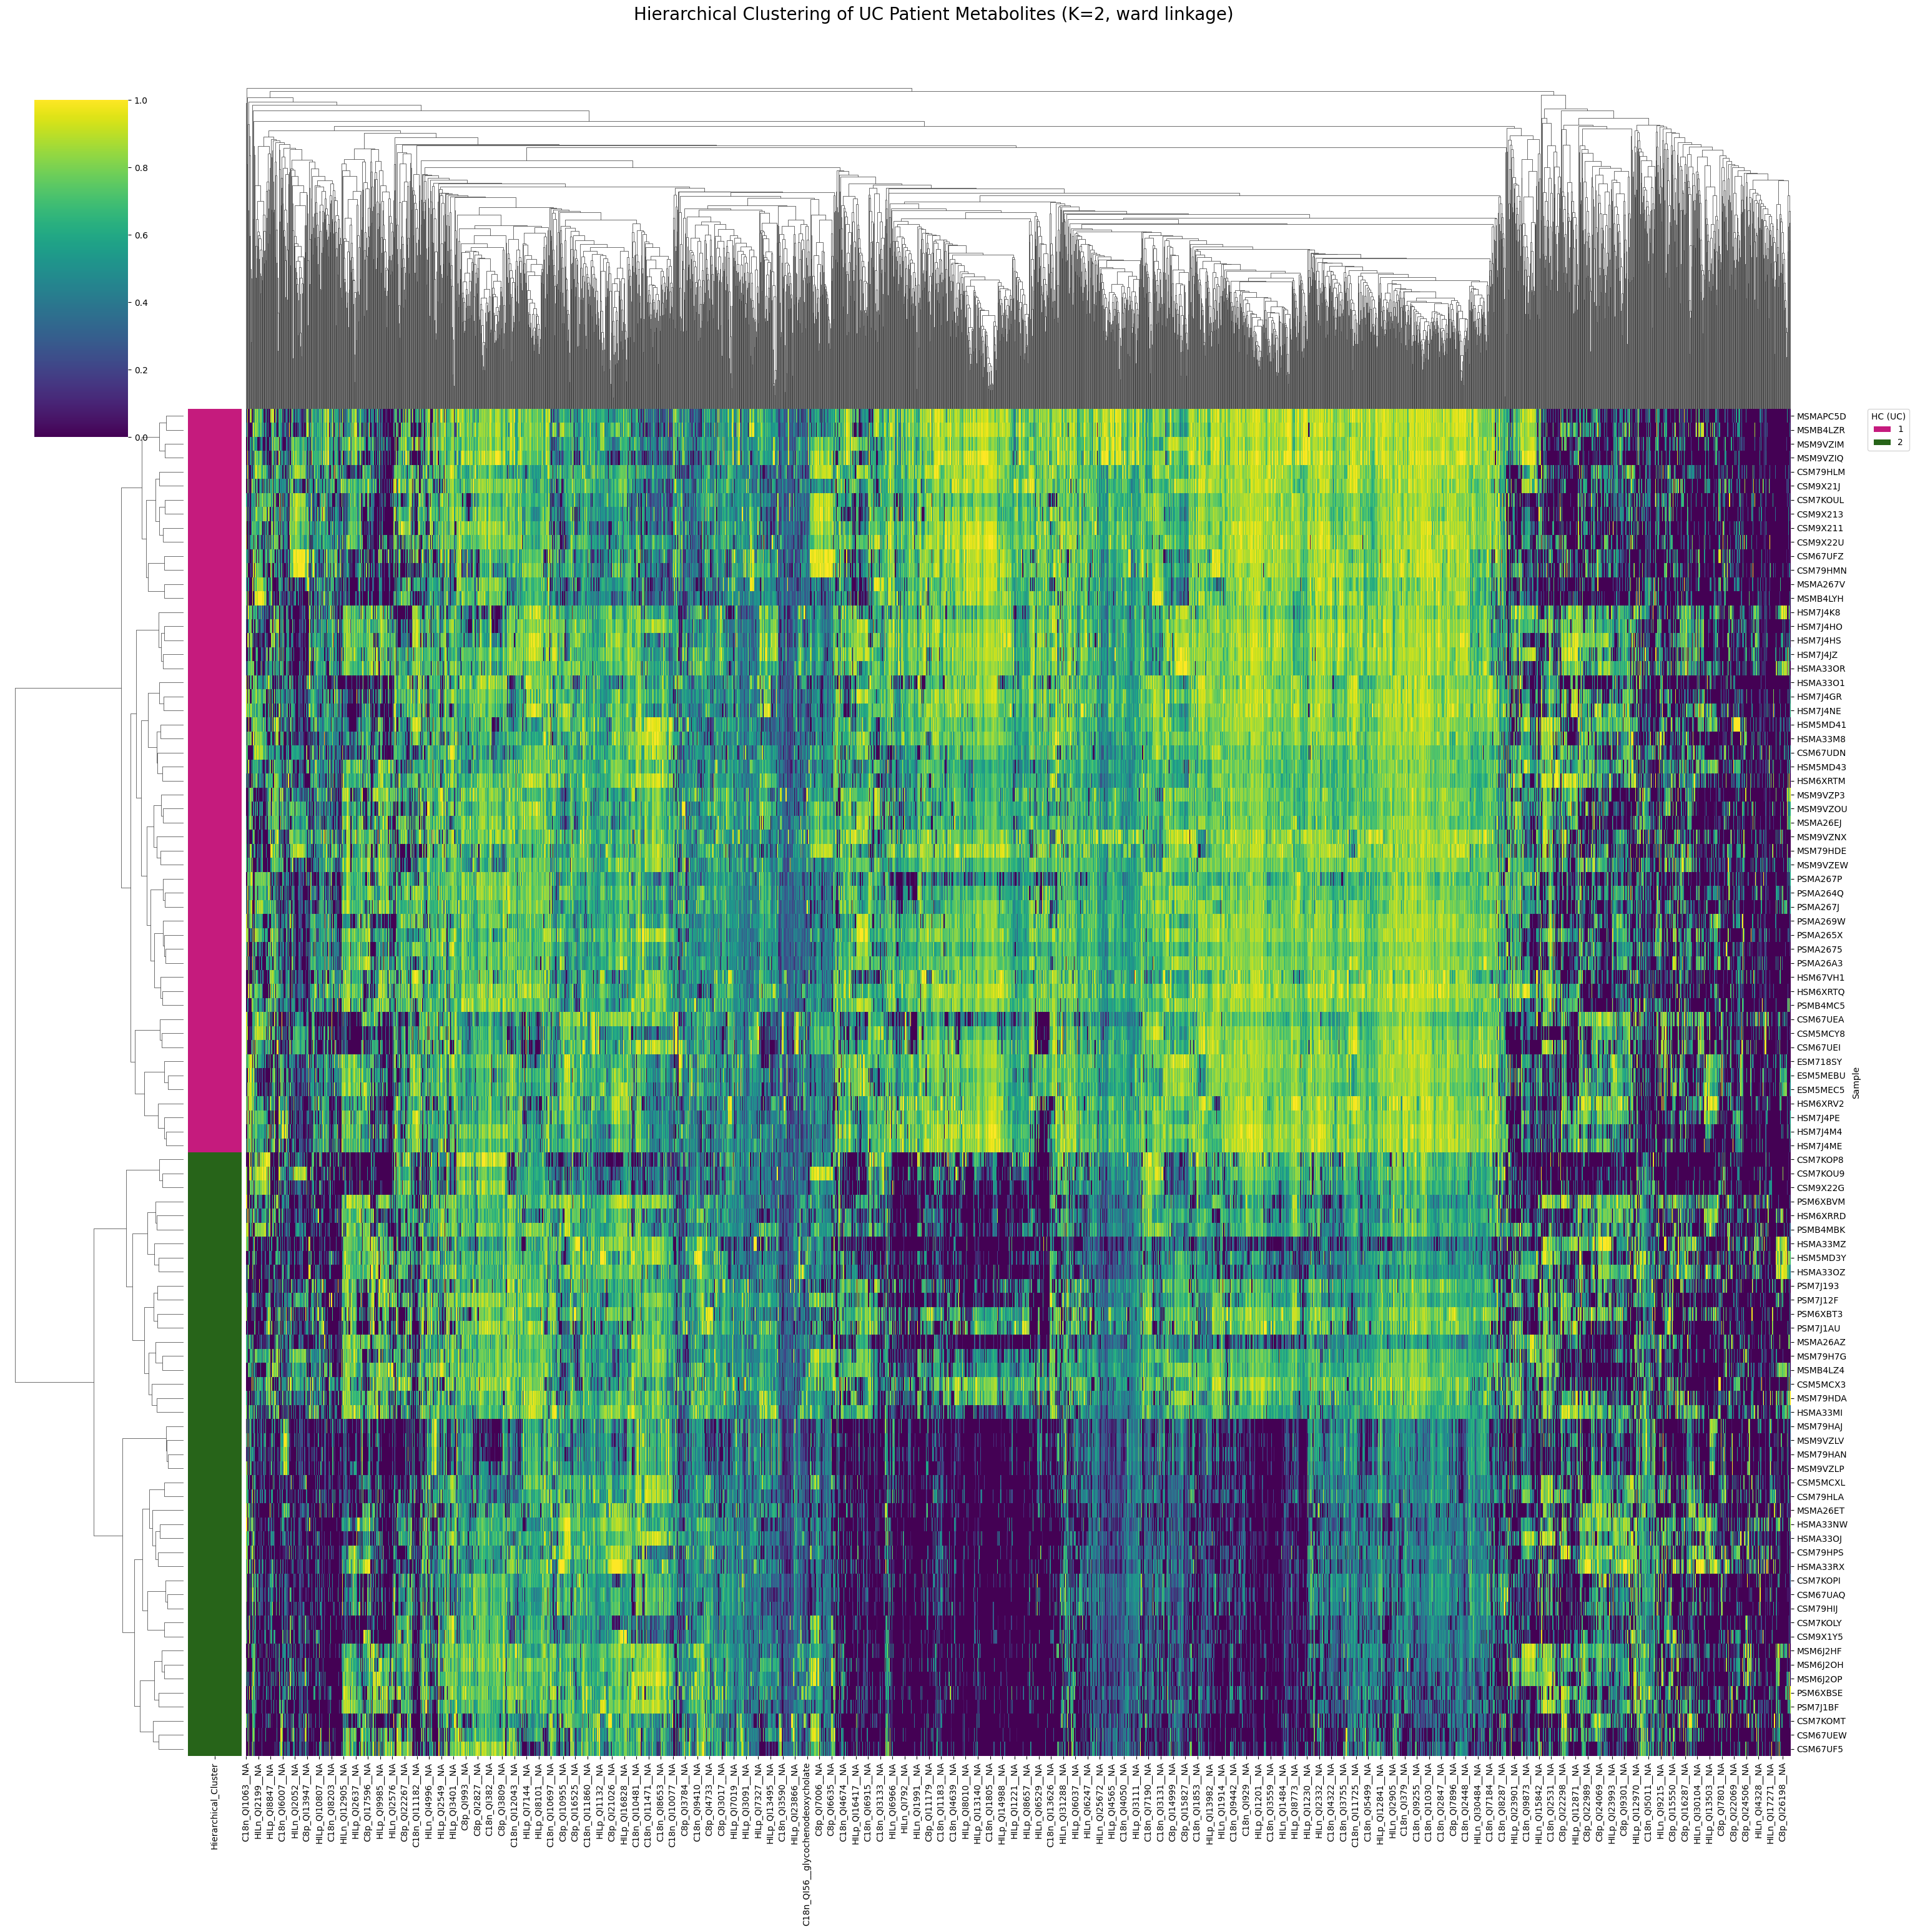

------------------------------
Saved UC data with Hierarchical cluster labels to processing_data/UC_hierarchical_clustered_data_not_boruta_k2.tsv
------------------------------

--- Analysis complete for UC ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# --- Libraries for Hierarchical Clustering ---
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.patches import Patch # For custom legends in clustermap

colors = ['#c51b7d', '#276419']  # Dark pink and dark green

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv'
dataset_name_prefix = 'UC' # For context

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
    print(f"Successfully loaded data from: {file_path_reduced_data}")
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found. Exiting.")
    exit()

print(f"--- K-means & Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

# --- 2. Filter for UC Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for patient group.")
    specific_group_df = pd.DataFrame()
else:
    # This makes the script flexible for 'UC' or 'UC' by changing dataset_name_prefix
    specific_group_df = full_processed_df[full_processed_df['Study.Group'] == dataset_name_prefix].copy()

if specific_group_df.empty or len(specific_group_df) < 2 : # Need at least 2 samples for clustering
    print(f"Not enough {dataset_name_prefix} patients found or remaining for subtype analysis (found {len(specific_group_df)}). Exiting.")
    scaled_features_group = None
else:
    print(f"Shape of {dataset_name_prefix}-only dataset: {specific_group_df.shape}")
    feature_columns_group = [col for col in specific_group_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_group:
        print(f"No feature columns found in {dataset_name_prefix}-only data.")
        scaled_features_group = None
    else:
        # This df holds the original (log-transformed, Boruta-selected) feature values for the group
        features_for_clustering_group = specific_group_df[feature_columns_group].copy()
        for col in features_for_clustering_group.columns:
            features_for_clustering_group[col] = pd.to_numeric(features_for_clustering_group[col], errors='coerce')
        
        features_for_clustering_group.dropna(axis=1, how='all', inplace=True)
        original_indices_group = features_for_clustering_group.index 
        features_for_clustering_group.dropna(axis=0, how='any', inplace=True) # Drop rows with any NaNs in features
        
        group_df_aligned = specific_group_df.loc[features_for_clustering_group.index].copy()

        if features_for_clustering_group.empty or features_for_clustering_group.shape[1] == 0:
            print(f"No valid feature data remains after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        elif features_for_clustering_group.shape[0] < 2:
            print(f"Not enough samples ({features_for_clustering_group.shape[0]}) remaining after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        else:
            scaler_group = StandardScaler()
            scaled_features_group = scaler_group.fit_transform(features_for_clustering_group)
            print(f"Using {scaled_features_group.shape[1]} features for clustering {scaled_features_group.shape[0]} {dataset_name_prefix} samples.")
            print("-" * 30)

# Proceed only if we have valid scaled features for the group
if scaled_features_group is not None and scaled_features_group.shape[0] > 1:

    # --- 3. Apply K-means Clustering (as per your existing script) ---
    chosen_k_kmeans = 2
    
    if chosen_k_kmeans >= scaled_features_group.shape[0]:
        print(f"Warning: chosen_k_kmeans ({chosen_k_kmeans}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K.")
    
    print(f"\n--- Applying K-means with K = {chosen_k_kmeans} for {dataset_name_prefix} Subtypes ---")

    kmeans_group = KMeans(n_clusters=chosen_k_kmeans, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
    cluster_labels_kmeans_group = kmeans_group.fit_predict(scaled_features_group)

    # Add K-means cluster labels to the aligned group DataFrame
    group_clustered_df_kmeans = group_df_aligned.copy()
    group_clustered_df_kmeans['KMeans_Cluster'] = cluster_labels_kmeans_group
    
    try:
        # Silhouette score requires at least 2 clusters and less clusters than samples.
        if 1 < len(np.unique(cluster_labels_kmeans_group)) < scaled_features_group.shape[0]:
            current_silhouette_score_kmeans = silhouette_score(scaled_features_group, cluster_labels_kmeans_group)
            print(f"Silhouette Score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {current_silhouette_score_kmeans:.4f}")
        else:
            print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): "
                  f"Number of unique labels ({len(np.unique(cluster_labels_kmeans_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
    except ValueError as e:
         print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {e}")
    print("-" * 30)

    # --- 4. Characterize K-means Clusters Numerically ---
    print(f"\n--- {dataset_name_prefix} Subtype K-means Cluster Characterization ---")
    print(f"Value counts for K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}):")
    print(group_clustered_df_kmeans['KMeans_Cluster'].value_counts().sort_index())
    print("-" * 30)

    # --- 5. Visualize K-means Clusters using PCA ---
    print(f"\n--- Visualizing {dataset_name_prefix} Subtype K-means Clusters with PCA ---")
    # PCA needs at least 2 components and n_samples >= n_components
    if scaled_features_group.shape[1] >= 2 and scaled_features_group.shape[0] >= 2:
        pca_for_group_viz = PCA(n_components=2, random_state=42)
        principal_components_group_viz = pca_for_group_viz.fit_transform(scaled_features_group)
        
        pca_group_viz_df = pd.DataFrame(
            data=principal_components_group_viz,
            columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
            index=group_clustered_df_kmeans.index # Use index from the clustered_df for proper alignment
        )
        
        # Combine PCA results with KMeans_Cluster labels and Sample IDs
        pca_group_viz_df = pd.concat([pca_group_viz_df, group_clustered_df_kmeans[['Sample', 'KMeans_Cluster']]], axis=1)

        plt.figure(figsize=(12, 9))
        sns.scatterplot(
            x=f'PC1_{dataset_name_prefix}_Subtype',
            y=f'PC2_{dataset_name_prefix}_Subtype',
            hue='KMeans_Cluster',
            palette=(colors * (chosen_k_kmeans // 2 + 1))[:chosen_k_kmeans],
            data=pca_group_viz_df,
            s=120,
            alpha=0.8
        )
        plt.title(f'K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}) on PCA (DAA Based)', 
                  fontsize=20, fontweight='semibold', pad=20)
        plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                   fontsize=20, fontweight='regular')
        plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                   fontsize=20, fontweight='regular')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(title=f'K-means {dataset_name_prefix} Cluster', fontsize=20, title_fontsize=20)
        legend.set_title(f'K-means {dataset_name_prefix} Cluster', prop={'size': 20, 'weight': 'regular'})
        plt.grid(False)
        plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough features/samples for PCA plot for {dataset_name_prefix} K-means subtypes.")
    print("-" * 30)

    # --- Save K-means clustered data ---
    output_filename_kmeans = f'processing_data/{dataset_name_prefix}_kmeans_clustered_data_not_boruta_k2.tsv'
    group_clustered_df_kmeans.to_csv(output_filename_kmeans, sep='\t', index=False)
    print(f"Saved {dataset_name_prefix} data with K-means cluster labels to {output_filename_kmeans}")
    print("-" * 30)


    ###########################################################################
    # --- NEXT STEPS: Hierarchical Clustering for UC Subtypes ---
    ###########################################################################
    print(f"\n--- Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

    # --- 6. Perform Hierarchical Clustering ---
    linkage_method = 'ward'  # Minimizes variance within clusters, good for general purpose
    metric = 'euclidean'     # Standard for scaled data with 'ward'

    print(f"Performing hierarchical clustering using '{linkage_method}' linkage and '{metric}' metric...")
    # `scaled_features_group` is the Z-scaled feature matrix for UC patients
    linked_matrix = linkage(scaled_features_group, method=linkage_method, metric=metric)

    # --- 7. Plot the Dendrogram ---
    plt.figure(figsize=(16, 10))
    dendrogram(linked_matrix,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               truncate_mode=None,
               color_threshold=0.7*max(linked_matrix[:,2]),
               above_threshold_color=colors[0]) # dark pink for branches above threshold
    plt.title(f'Hierarchical Clustering Dendrogram for {dataset_name_prefix} Patients ({linkage_method} linkage)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xlabel("Sample Index / Cluster", fontsize=20, fontweight='semibold')
    plt.ylabel(f"Distance ({metric})", fontsize=20, fontweight='semibold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # --- 8. Determine Clusters from Dendrogram & Assign Labels ---
    num_clusters_hc = chosen_k_kmeans
    
    if num_clusters_hc >= scaled_features_group.shape[0] :
        print(f"Warning: num_clusters_hc ({num_clusters_hc}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K_hc.")
        # Cap num_clusters_hc if it's too high for meaningful clustering or silhouette score
        if scaled_features_group.shape[0] > 1:
            num_clusters_hc = max(2, scaled_features_group.shape[0] -1) # Ensure at least 2 clusters if possible, but less than N
            print(f"Adjusted num_clusters_hc to {num_clusters_hc}")
        else: # Should not happen due to earlier checks, but defensive
             print(f"Cannot perform hierarchical clustering with {scaled_features_group.shape[0]} samples.")
             # Skip further HC steps if this edge case is hit
             num_clusters_hc = 0


    if num_clusters_hc > 0: # if num_clusters_hc is valid
        print(f"Cutting dendrogram to obtain {num_clusters_hc} clusters...")
        cluster_labels_hc_group = fcluster(linked_matrix, num_clusters_hc, criterion='maxclust')

        # Add Hierarchical Cluster labels to a new DataFrame
        group_clustered_df_hc = group_df_aligned.copy() # proceed with the same aligned group data
        group_clustered_df_hc['Hierarchical_Cluster'] = cluster_labels_hc_group
        
        # --- 9. Characterize Hierarchical Clusters ---
        print(f"\n--- {dataset_name_prefix} Subtype Hierarchical Cluster Characterization ---")
        print(f"Value counts for Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}):")
        print(group_clustered_df_hc['Hierarchical_Cluster'].value_counts().sort_index())

        try:
            if 1 < len(np.unique(cluster_labels_hc_group)) < scaled_features_group.shape[0]:
                silhouette_avg_hc = silhouette_score(scaled_features_group, cluster_labels_hc_group)
                print(f"Silhouette Score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {silhouette_avg_hc:.4f}")
            else:
                print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): "
                      f"Number of unique labels ({len(np.unique(cluster_labels_hc_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
        except ValueError as e:
            print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {e}")
        print("-" * 30)

        # --- 10. Visualize Hierarchical Clusters using PCA (for comparison with K-means) ---
        print(f"\n--- Visualizing {dataset_name_prefix} Subtype Hierarchical Clusters with PCA ---")
        if 'pca_for_group_viz' in locals() and pca_for_group_viz is not None:
            pca_group_viz_df_hc = pd.DataFrame(
                data=principal_components_group_viz,
                columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
                index=group_clustered_df_hc.index
            )
            pca_group_viz_df_hc = pd.concat([pca_group_viz_df_hc, group_clustered_df_hc[['Sample', 'Hierarchical_Cluster']]], axis=1)

            plt.figure(figsize=(12, 9))
            sns.scatterplot(
                x=f'PC1_{dataset_name_prefix}_Subtype',
                y=f'PC2_{dataset_name_prefix}_Subtype',
                hue='Hierarchical_Cluster',
                palette=(colors * (num_clusters_hc // 2 + 1))[:num_clusters_hc],
                data=pca_group_viz_df_hc,
                s=120,
                alpha=0.8
            )
            plt.title(f'Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}) on PCA', 
                      fontsize=20, fontweight='semibold', pad=20)
            plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                       fontsize=20, fontweight='regular')
            plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                       fontsize=20, fontweight='regular')
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            legend = plt.legend(title=f'Hierarchical {dataset_name_prefix} Cluster', fontsize=20, title_fontsize=20)
            legend.set_title(f'Hierarchical {dataset_name_prefix} Cluster', prop={'size': 20, 'weight': 'regular'})
            plt.grid(False)
            plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"PCA components not available for visualizing Hierarchical clusters for {dataset_name_prefix}.")
        print("-" * 30)

        # --- 11. Visualize with Clustermap (Heatmap with Dendrograms) ---
        print(f"\n--- Generating Clustermap for {dataset_name_prefix} Subtypes (Hierarchical Clustering) ---")
        
        data_for_heatmap_group = features_for_clustering_group.copy()
        # Set Sample IDs as index if they are not already (for labeling heatmap rows), should already be done though
        if 'Sample' in group_df_aligned.columns:
             data_for_heatmap_group.index = group_df_aligned['Sample']
        
        # Create a Series for row colors based on hierarchical cluster, indexed by Sample ID
        cluster_series_hc = group_clustered_df_hc.set_index('Sample')['Hierarchical_Cluster']
        
        unique_hc_clusters = sorted(cluster_series_hc.unique())
        palette_hc_map = (colors * (len(unique_hc_clusters) // 2 + 1))[:len(unique_hc_clusters)]
        cluster_color_map_hc = {cluster_val: color for cluster_val, color in zip(unique_hc_clusters, palette_hc_map)}
        row_colors_hc_mapped = cluster_series_hc.map(cluster_color_map_hc)
        
        # Ensure row_colors_hc_mapped is aligned with data_for_heatmap_group
        # This should be fine because both used 'Sample' as index from group_df_aligned/group_clustered_df_hc
        if not data_for_heatmap_group.index.equals(row_colors_hc_mapped.index):
            print("Warning: Index mismatch between heatmap data and row colors. Attempting to align.")
            try:
                row_colors_hc_mapped = row_colors_hc_mapped.reindex(data_for_heatmap_group.index)
            except Exception as e:
                print(f"Could not align row_colors with heatmap data: {e}. Clustermap might not have row colors.")


        if data_for_heatmap_group.shape[0] > 1 and data_for_heatmap_group.shape[1] > 1:
            print(f"Generating clustermap with {data_for_heatmap_group.shape[0]} samples and {data_for_heatmap_group.shape[1]} features.")
            try:
                g = sns.clustermap(
                    data_for_heatmap_group,      # Original selected features (log-transformed)
                    row_linkage=linked_matrix,   # Using pre-computed linkage for rows (samples)
                    cmap="viridis",              # Colormap for the heatmap values
                    standard_scale=1,            # Z-score features (columns) for visualization
                    row_colors=row_colors_hc_mapped if not row_colors_hc_mapped.isnull().all() else None,
                    figsize=(min(30, 0.8 * data_for_heatmap_group.shape[1]), # Width based on num features
                             min(30, 0.4 * data_for_heatmap_group.shape[0] + 5)), # Height based on num samples
                    dendrogram_ratio=(.1, .2)
                )
                g.fig.suptitle(f'Hierarchical Clustering of {dataset_name_prefix} Patient Metabolites (K={num_clusters_hc}, {linkage_method} linkage)', y=1.03, fontsize=20)

                if not row_colors_hc_mapped.isnull().all():
                    handles = [Patch(facecolor=cluster_color_map_hc[name]) for name in unique_hc_clusters if name in cluster_color_map_hc]
                    if handles:
                        legend_title = f'HC ({dataset_name_prefix})'
                        g.ax_heatmap.legend(handles, unique_hc_clusters, title=legend_title,
                                            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.show()
            except Exception as e:
                print(f"Error generating clustermap: {e}")
                print("This can happen if there are too few samples/features or issues with linkage/data.")

        else:
            print(f"Not enough samples or features for Clustermap for {dataset_name_prefix} subtypes.")
        print("-" * 30)

        # --- 12. Save DataFrame with Hierarchical Cluster labels ---
        output_filename_hc = f'processing_data/{dataset_name_prefix}_hierarchical_clustered_data_not_boruta_k2.tsv'
        group_clustered_df_hc.to_csv(output_filename_hc, sep='\t', index=False)
        print(f"Saved {dataset_name_prefix} data with Hierarchical cluster labels to {output_filename_hc}")
        print("-" * 30)
    else:
        print(f"Hierarchical clustering skipped for {dataset_name_prefix} due to invalid number of clusters ({num_clusters_hc}).")


else:
    print(f"K-means and Hierarchical clustering for {dataset_name_prefix} subtypes skipped as no valid feature data was available or insufficient samples.")

print(f"\n--- Analysis complete for {dataset_name_prefix} ---")

UC - DAA with k=2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/filtered_log_transformed_mtb_overlap.tsv' 
dataset_name_script = 'UC_K2_DAA' # Context
chosen_k_uc = 2 # Focusing on K=2 for UC subtypes

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found.")
else:
    if 'Study.Group' not in full_processed_df.columns:
        print("Error: 'Study.Group' column not found in loaded data. Cannot filter for UC patients.")
        uc_only_df = pd.DataFrame() 
    else:
        uc_only_df = full_processed_df[full_processed_df['Study.Group'] == 'UC'].copy()

print(f"--- Corrected K-means for UC Subtype Clusters (K={chosen_k_uc}) & Saving ---")

if uc_only_df.empty or len(uc_only_df) < chosen_k_uc : 
    print(f"Not enough UC patients found ({len(uc_only_df)}) or remaining for K={chosen_k_uc} subtype analysis. Exiting.")
else:
    print(f"Shape of UC-only dataset: {uc_only_df.shape}")
    feature_columns_uc = [col for col in uc_only_df.columns if col not in ['Sample', 'Study.Group']] 

    if not feature_columns_uc:
        print("No feature columns found for clustering.")
    else:
        features_for_clustering_uc = uc_only_df[feature_columns_uc].copy()
        for col in features_for_clustering_uc.columns: 
            features_for_clustering_uc[col] = pd.to_numeric(features_for_clustering_uc[col], errors='coerce')
        
        features_for_clustering_uc.dropna(axis=1, how='all', inplace=True)
        original_indices_uc = features_for_clustering_uc.index 
        features_for_clustering_uc.dropna(axis=0, how='all', inplace=True)
        uc_only_df_aligned = uc_only_df.loc[features_for_clustering_uc.index] # Align original UC data
        
        current_uc_feature_list_for_daa = features_for_clustering_uc.columns.tolist()

        if features_for_clustering_uc.empty:
            print("No valid UC feature data for clustering.")
        else:
            scaler_uc = StandardScaler()
            scaled_features_uc = scaler_uc.fit_transform(features_for_clustering_uc)

            kmeans_uc = KMeans(n_clusters=chosen_k_uc, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_uc = kmeans_uc.fit_predict(scaled_features_uc)
            
            # This is the DataFrame that contains the original UC data aligned with clustering input
            uc_clustered_df = uc_only_df_aligned.copy() 
            uc_cluster_col_name = f'KMeans_Cluster_UC_K{chosen_k_uc}' # This will be 'KMeans_Cluster_UC_K2'
            uc_clustered_df[uc_cluster_col_name] = cluster_labels_uc
            os.makedirs('processing_data/uc_clusters', exist_ok=True)
            output_clustered_filename = 'processing_data/uc_clusters/uc_clustered_df_k2.tsv' # the file for visualizations
            uc_clustered_df.to_csv(output_clustered_filename, sep='\t', index=False)
            
            print(f"\nK-means clustering (K={chosen_k_uc}) for UC samples complete.")
            print(f"DataFrame with UC samples and K={chosen_k_uc} cluster labels saved to: {output_clustered_filename}")
            print("UC Subtype Cluster sizes based on this run:")
            print(uc_clustered_df[uc_cluster_col_name].value_counts().sort_index())
            print("\nContents of the saved file (first 5 rows):")
            print(pd.read_csv(output_clustered_filename, sep='\t').head())
            print(f"\nMake sure the column '{uc_cluster_col_name}' is present in the saved file.")
            print("-" * 30)

            # --- 3. Define DAA Function (same as before) ---
            def perform_cluster_daa(df, features_list, cluster_col_name, cluster1_label, cluster2_label, top_n=20):
                print(f"\n--- DAA: UC Subtype Cluster {cluster1_label} vs Cluster {cluster2_label} ---")
                group1_df = df[df[cluster_col_name] == cluster1_label]
                group2_df = df[df[cluster_col_name] == cluster2_label]

                if len(group1_df) < 2 or len(group2_df) < 2:
                    print(f"Not enough samples for DAA between C{cluster1_label} ({len(group1_df)}) and C{cluster2_label} ({len(group2_df)}).")
                    return pd.DataFrame(), pd.DataFrame() 

                group1_features = group1_df[features_list]
                group2_features = group2_df[features_list]
                
                cluster_results = []
                for feature in features_list:
                    g1_vals = group1_features[feature].dropna()
                    g2_vals = group2_features[feature].dropna()
                    if len(g1_vals) < 2 or len(g2_vals) < 2: continue
                    
                    t_stat, p_value = stats.ttest_ind(g1_vals, g2_vals, equal_var=False, nan_policy='omit')
                    mean_g1_log = np.mean(g1_vals); mean_g2_log = np.mean(g2_vals)
                    log2_fc = mean_g1_log - mean_g2_log
                    mean_g1_orig = np.mean(np.expm1(g1_vals)); mean_g2_orig = np.mean(np.expm1(g2_vals))
                    fold_change_orig = np.nan
                    if pd.notna(mean_g2_orig) and mean_g2_orig != 0 and pd.notna(mean_g1_orig):
                        fold_change_orig = mean_g1_orig / mean_g2_orig
                    
                    cluster_results.append({
                        'Feature': feature, 'P_Value': p_value,
                        f'Mean_Log_UC_C{cluster1_label}': mean_g1_log, f'Mean_Log_UC_C{cluster2_label}': mean_g2_log,
                        'Log2_Fold_Change_on_LogData': log2_fc, 
                        'Fold_Change_OrigScale': fold_change_orig
                    })
                
                results_df = pd.DataFrame(cluster_results)
                if results_df.empty or 'P_Value' not in results_df.columns or results_df['P_Value'].isnull().all():
                    print("No valid P_Values for this comparison."); return pd.DataFrame(), pd.DataFrame()
                results_df.dropna(subset=['P_Value'], inplace=True)
                if results_df.empty: print("No results after P_Value NaN drop."); return pd.DataFrame(), pd.DataFrame()

                reject, pvals_corrected, _, _ = multipletests(results_df['P_Value'], method='fdr_bh')
                results_df['Adjusted_P_Value'] = pvals_corrected
                results_df = results_df.sort_values(by='Adjusted_P_Value')
                
                significant_hits = results_df[results_df['Adjusted_P_Value'] < 0.05]
                print(f"Top {top_n} differentiating features between UC Subtype Cluster {cluster1_label} and Cluster {cluster2_label} (FDR < 0.05):")
                print(significant_hits[['Feature', 'Adjusted_P_Value', 'Log2_Fold_Change_on_LogData', 'Fold_Change_OrigScale']].head(top_n))
                print(f"Found {len(significant_hits)} significant features for UC Subtype Cluster {cluster1_label} vs {cluster2_label} at FDR < 0.05.")
                return results_df, significant_hits

            # --- 4. Pairwise DAA Between K=2 UC Subtype Clusters ---
            if not uc_clustered_df.empty and uc_cluster_col_name in uc_clustered_df.columns:
                print(f"\nStarting DAA for K={chosen_k_uc} UC Subtype clusters.")
                # For K=2, we only have one comparison: Cluster 0 vs Cluster 1
                daa_UC_C0_vs_C1_all, daa_UC_C0_vs_C1_sig = perform_cluster_daa(uc_clustered_df, current_uc_feature_list_for_daa, uc_cluster_col_name, 0, 1, top_n=20)
                print("-" * 30)
                print("DAA between UC Subtype clusters complete.")
                if not daa_UC_C0_vs_C1_sig.empty: 
                    daa_UC_C0_vs_C1_sig.to_csv(f'processing_data/uc_clusters/DAA_sig_{dataset_name_script}_C0vC1.tsv', sep='\t', index=False)
            else:
                print("Clustered UC DataFrame is empty or missing cluster labels. Cannot perform DAA.")

--- Corrected K-means for UC Subtype Clusters (K=2) & Saving ---
Shape of UC-only dataset: (96, 3295)

K-means clustering (K=2) for UC samples complete.
DataFrame with UC samples and K=2 cluster labels saved to: processing_data/uc_clusters/uc_clustered_df_k2.tsv
UC Subtype Cluster sizes based on this run:
KMeans_Cluster_UC_K2
0    65
1    31
Name: count, dtype: int64

Contents of the saved file (first 5 rows):
     Sample Study.Group  C18n_QI56__glycochenodeoxycholate  \
0  ESM5MEBU          UC                          15.250384   
1  HSM5MD43          UC                          13.471000   
2  MSM6J2HF          UC                          15.309189   
3  CSM5MCXL          UC                          14.021495   
4  CSM5MCY8          UC                          13.815588   

   C18n_QI66__salicylate  C18n_QI1577__NA  C18n_QI2961__NA  C18n_QI3444__NA  \
0              11.452220         8.989569         8.507345        10.433792   
1              10.412592         8.166500         9.443

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Top 20 differentiating features between UC Subtype Cluster 0 and Cluster 1 (FDR < 0.05):
               Feature  Adjusted_P_Value  Log2_Fold_Change_on_LogData  \
2668   HILp_QI2089__NA      3.442673e-58                     6.545607   
2857  HILp_QI13145__NA      5.104056e-52                    10.163198   
2665   HILp_QI1225__NA      1.308576e-51                     6.716752   
2682   HILp_QI2090__NA      5.850931e-51                     6.147956   
2786   HILp_QI8658__NA      1.082028e-47                     7.397498   
2692   HILp_QI1292__NA      2.187045e-46                     8.955557   
2779   HILp_QI8657__NA      8.659761e-46                     4.556589   
293    C18n_QI2510__NA      2.037188e-42                    10.331120   
2931  HILp_QI13141__NA      2.017073e-41                    10.826557   
17      C18n_QI214__NA      2.473171e-41                     4.500371   
2705   HILp_QI2033__NA      2.473171e-41                     3.862934   
2917  HILp_QI13142__NA      6.14102